# GE analysis in clones across transplantation timepoints

In [2]:
library(ggplot2)
library(ggrepel)
library(plyr)
library(dplyr)
library(Seurat)
library(tidyr) 
library(DescTools)
library(parallel)
library(ggbeeswarm)
library(forcats)
library(parameters)
library(stringr)
library(RColorBrewer)

source("../sc_analysis_palettes_and_helpers.r")

dat_name <- "allClones_allTPs"

## Load NB cell data with modules scores and clone info

In [4]:
# Load Seurat metadata with high-resolution clone assignments and module scores
dat <- readRDS('./data/seur_obj_allmerged_final_NB_with_clones_and_scores_withLowResClones.rds')


In [6]:
# Load final module table
modules_pan <- read.delim('../gene_modules/final_gene_modules_list.csv', sep = ',', stringsAsFactors = F, header = T)

# Re-format into list
modules_pan <- as.list(modules_pan)

# Double-check that common gene names contain correct set of special characters
modules_pan <- lapply(modules_pan, function(x) gsub("si\\.","si:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("zgc\\.","zgc:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("mt\\.","mt-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("dkey\\.","dkey-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("h211\\.","h211-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("ch73\\.","ch73-",x))

# Remove empty entries
modules_pan <- lapply(modules_pan, function(x) {
  # Remove NA and empty string "" entries
  x[!(is.na(x) | x == "")]
})

# Remove modules that are too short
modules_pan <- modules_pan[lengths(modules_pan) > 5]

## Plot individual clones across timepoints

In the following, we prepare the data and then generate plots for NB cells from individual clones separately.  
First, metadata columns are prepared for plotting.  
Then the following is done for all clones separately:  
- Subsetting of Seurat object for cells from clone; processing and clustering of the subset of cells.
- UMAPs showing cells colored by seurat clusters, sample type and other metadata information.
- Barplots showing the fraction of cells from each clone assigned to each seurat cluster.
- Boxplots of module expression scores in cells grouped by sample type (primary tumor vs. allograft).

In [7]:
# Add a few more info columns to metadata in preparation

# Unambiguous tumor identifier
dat@meta.data$sample_tumour <- paste0(dat@meta.data$dataset,'_',dat@meta.data$fish_id, '_', dat@meta.data$tumor_id)

# Unambiguous fish identifier
dat@meta.data$sample_fish <- paste0(dat@meta.data$dataset,'_',dat@meta.data$fish_id)

# Unambiguous tumor identifier with location info
dat@meta.data$sample_tumour_loc <- paste0(dat@meta.data$sample_tumour ,'_',dat@meta.data$location)


# Unambiguous sub-tumor and clone identifier
dat@meta.data$location_clones <- 'none'
dat@meta.data$location_clones <- paste0(dat@meta.data$fish_clone,'_tum_',dat@meta.data$tumor_id)

# Unambiguous fish and clone identifier
dat@meta.data$fish_loc_clone <- paste0(dat@meta.data$fish_clone ,'_loc_',dat@meta.data$location)

## Add a shortened cloneID
dat@meta.data$cloneID[!is.na(dat@meta.data$fish_clone)] <- sub(".*clone_", "", dat$fish_clone[!is.na(dat@meta.data$fish_clone)])
dat@meta.data$cloneID <- trimws(dat@meta.data$cloneID)
dat@meta.data$cloneID <- as.character(as.factor(dat@meta.data$cloneID))

dat@meta.data$sample_fish <- as.factor(dat@meta.data$sample_fish)

In [8]:
# Add a sample-clone identifier, in which early allograft cells are grouped by experiment (instead of per larval batch) and clone.
dat@meta.data$sample_sum <- dat@meta.data$sample_ID
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b1%'] <- 'early_allos_b1'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b2%'] <- 'early_allos_b2'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b3%'] <- 'early_allos_b3'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b4%'] <- 'early_allos_b4'

dat@meta.data$tumorsample_clone <- paste0(dat@meta.data$sample_sum,'_',dat@meta.data$fish_clone)


In [9]:
# Remove clonal label for clones that have fewer than 10 cells
clone_freqs <- as.data.frame(table(dat@meta.data$tumorsample_clone))
clone_freqs <- clone_freqs[clone_freqs$Freq < 10,]

dat@meta.data$cloneID[dat@meta.data$tumorsample_clone %in% clone_freqs$Var1] <- NA
dat@meta.data$fish_clone[dat@meta.data$tumorsample_clone %in% clone_freqs$Var1] <- NA
dat@meta.data$tumorsample_clone[dat@meta.data$tumorsample_clone %in% clone_freqs$Var1] <- NA


In [10]:
# Set module scores to plot
b1 <- 1
b2 <- length(modules_pan)

# Select score_type to look at
score_type <- 'auc'

# Select modules to plot for all clones in the loop below
module_metnames <- names(modules_pan)

set_all <- module_metnames[1:length(module_metnames)]
set_name <- 'set_all'

# Add ID to module number depending on assay used
if(score_type == 'barkley'){
    set_all <- paste0('barkley_',set_all)
}else if(score_type == 'auc'){
    set_all <- paste0('auc_',set_all)       
}

In [14]:
# Set samples to plot. Only use those where the late allograft sample has at least 10 cells in a clone:
clones_late <- dat@meta.data$clone_all_tps[dat@meta.data$sample_type == 'late_allograft']
freqs_clones <- as.data.frame(table(clones_late))
freqs_clones <- as.character(freqs_clones$clones_late[freqs_clones$Freq > 10])

[1] "Working on dataset: multi_seq_09_2_6"
[1] "Number of cells: 1421"


Centering and scaling data matrix



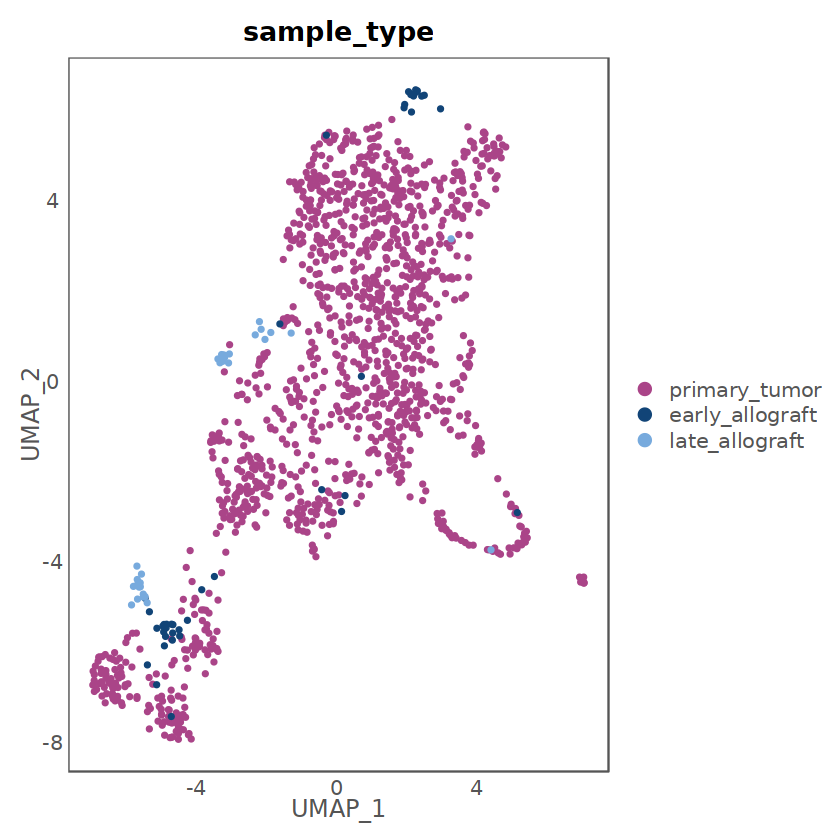

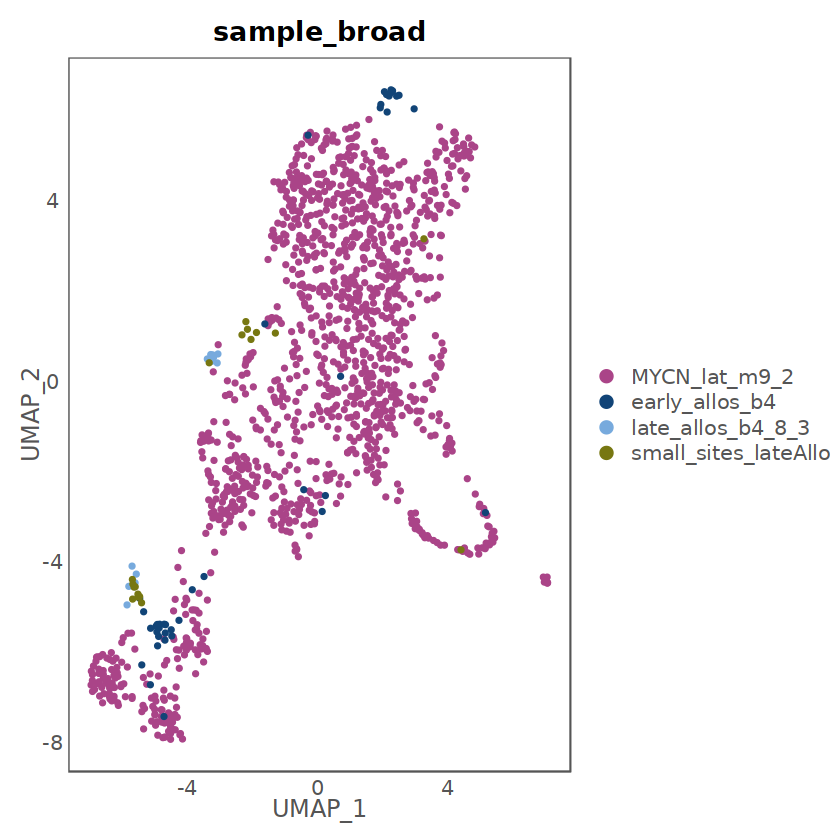

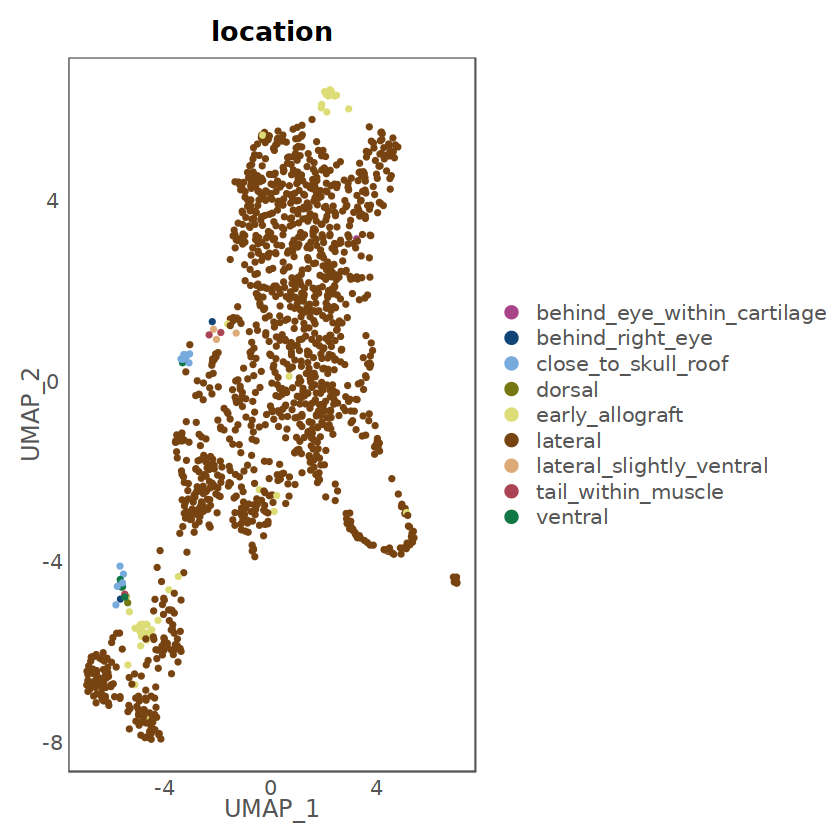

[1] "Plotting module score boxplots"


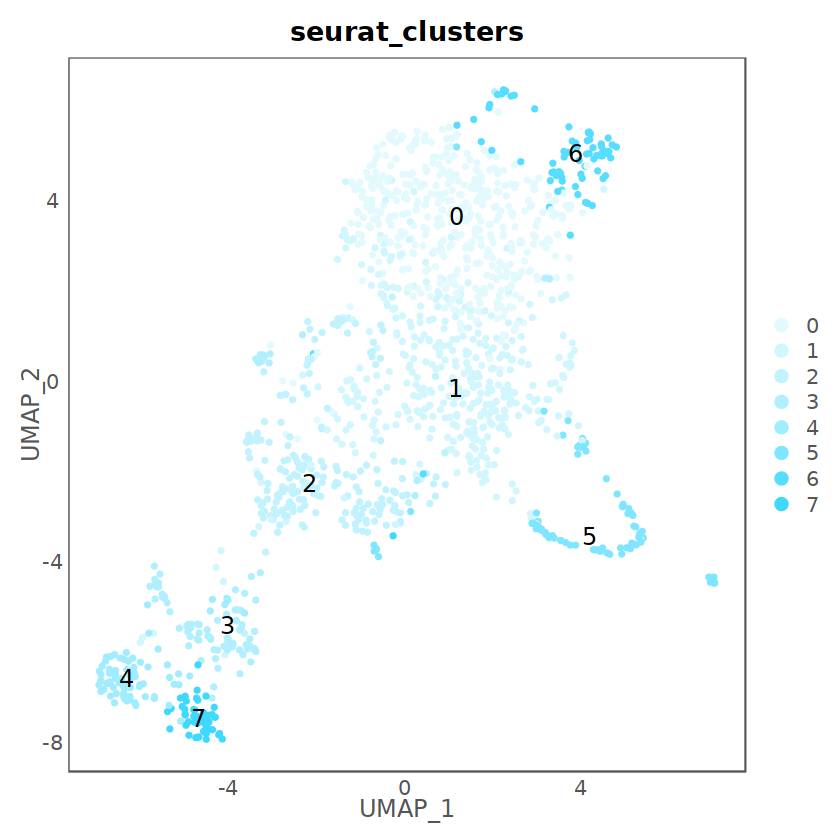

[1] "Working on dataset: multi_seq_09_3_4"
[1] "Number of cells: 431"


Centering and scaling data matrix



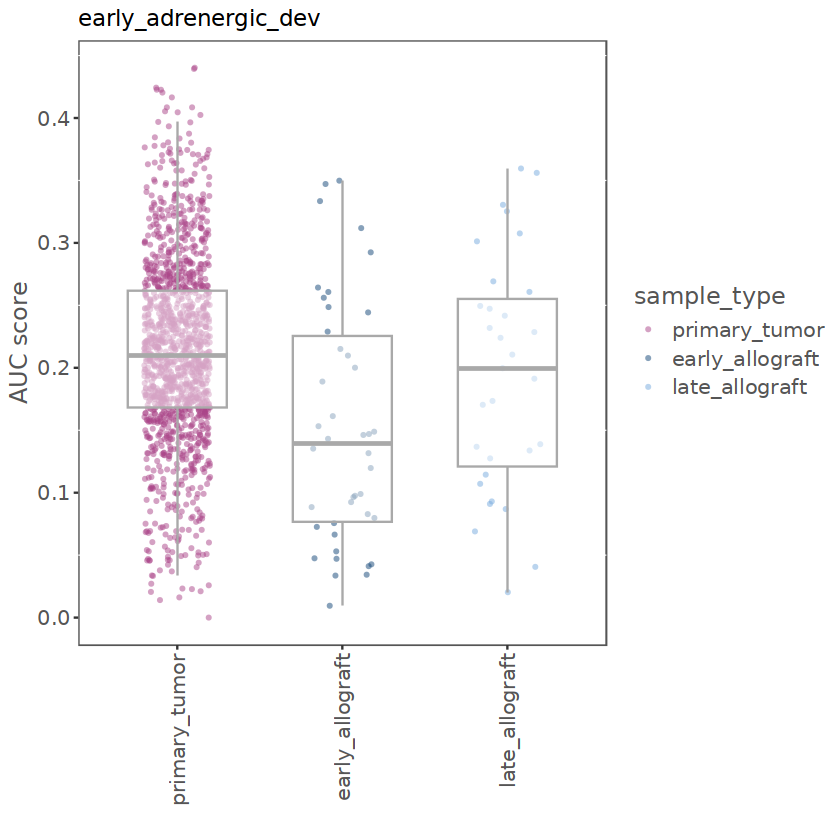

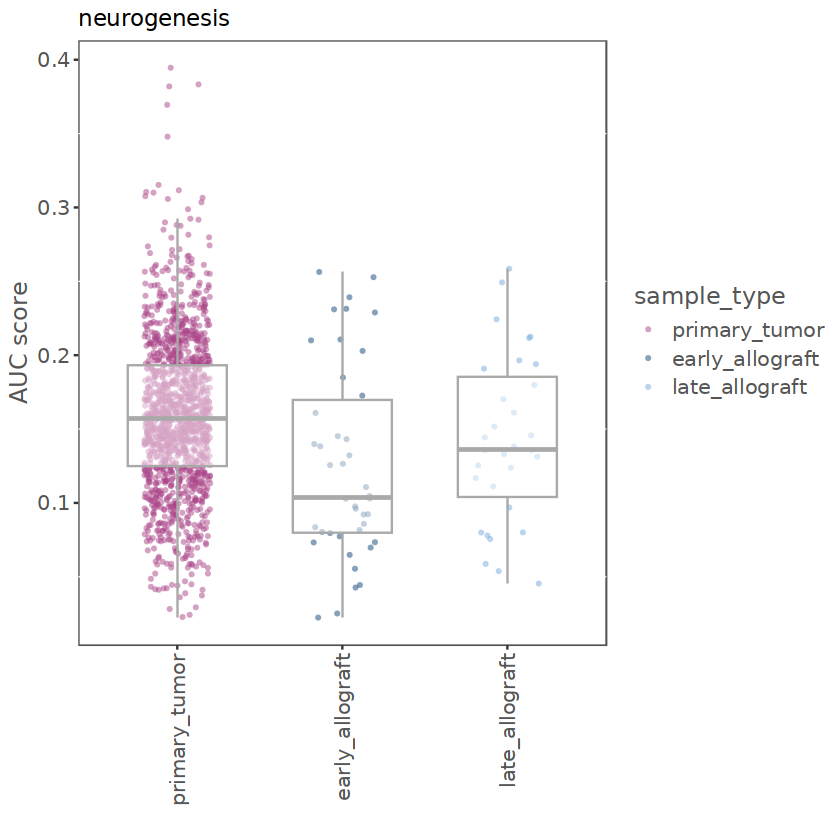

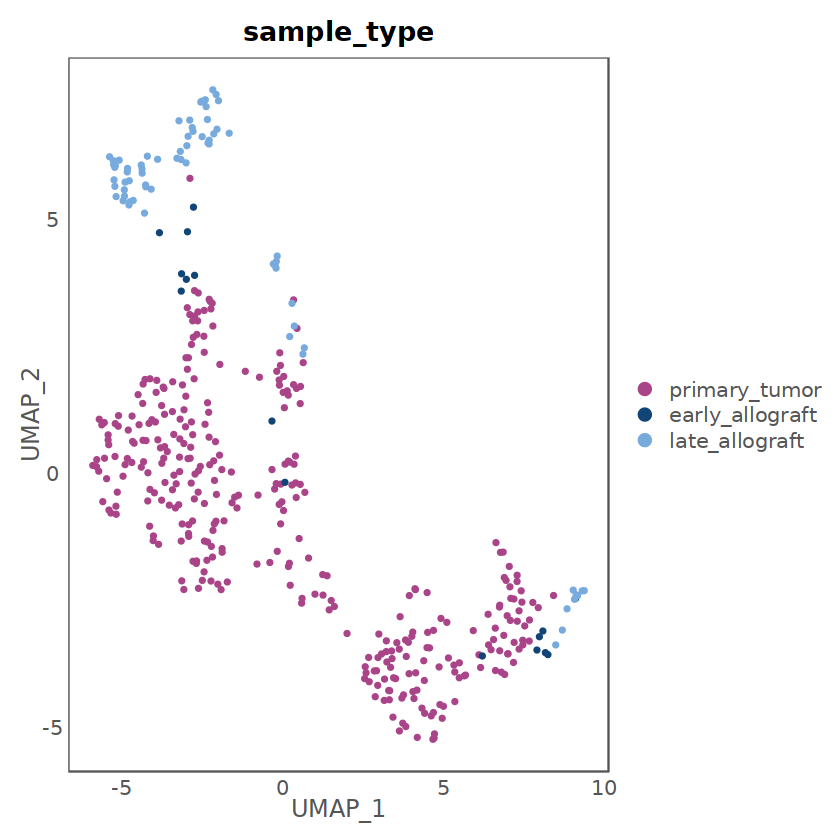

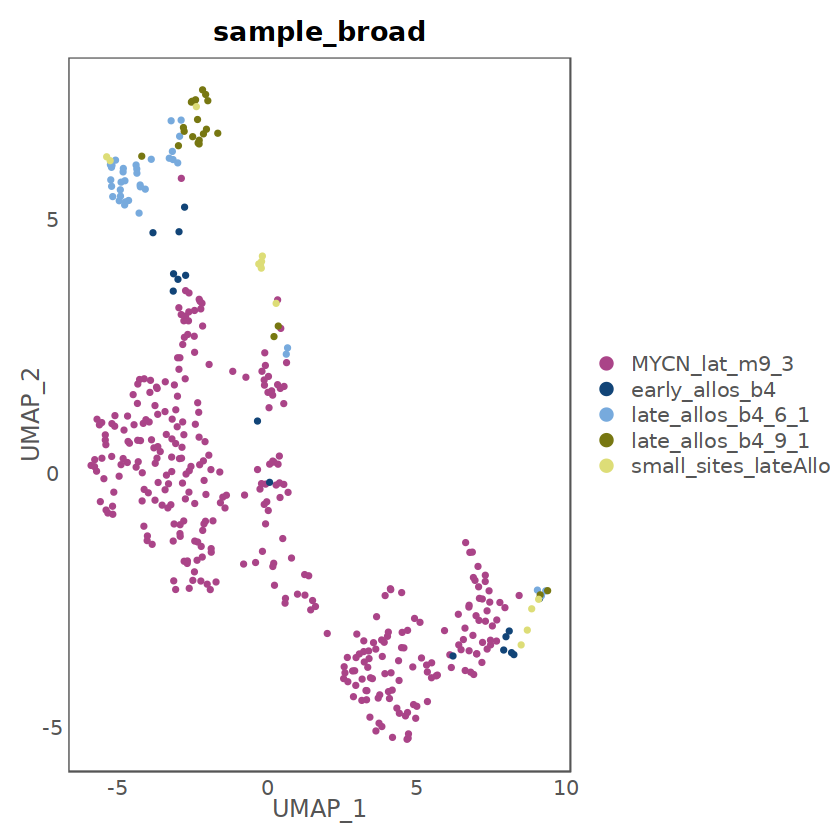

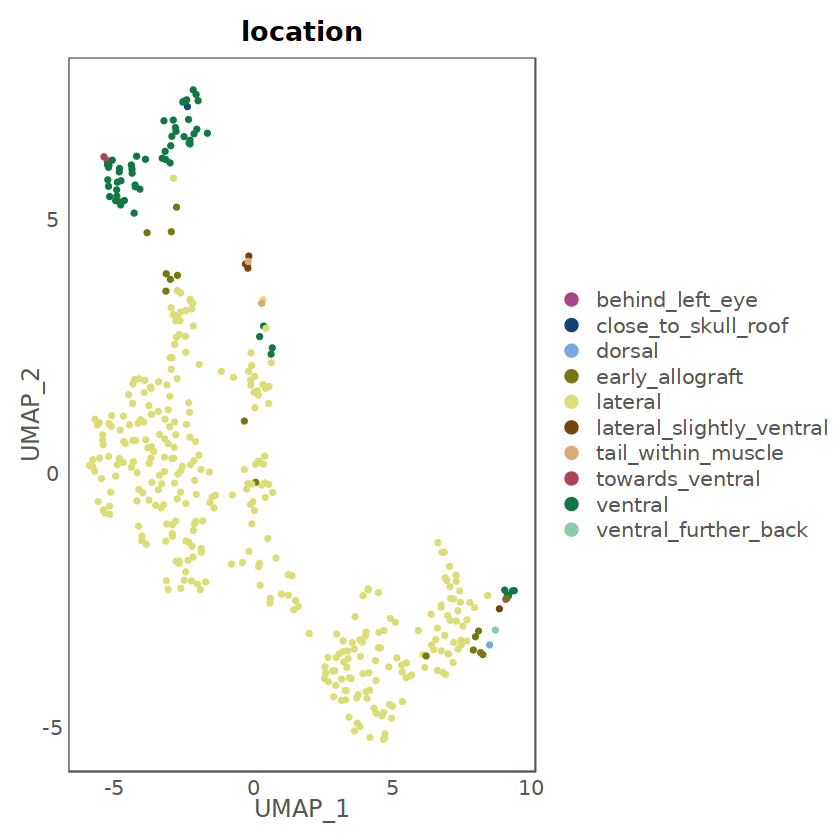

[1] "Plotting module score boxplots"


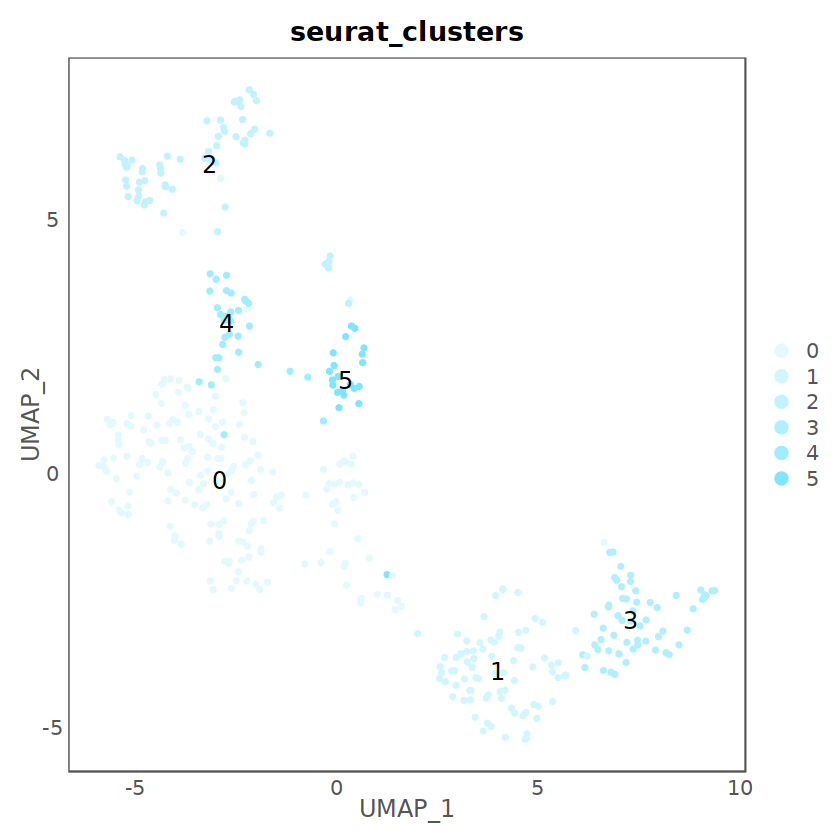

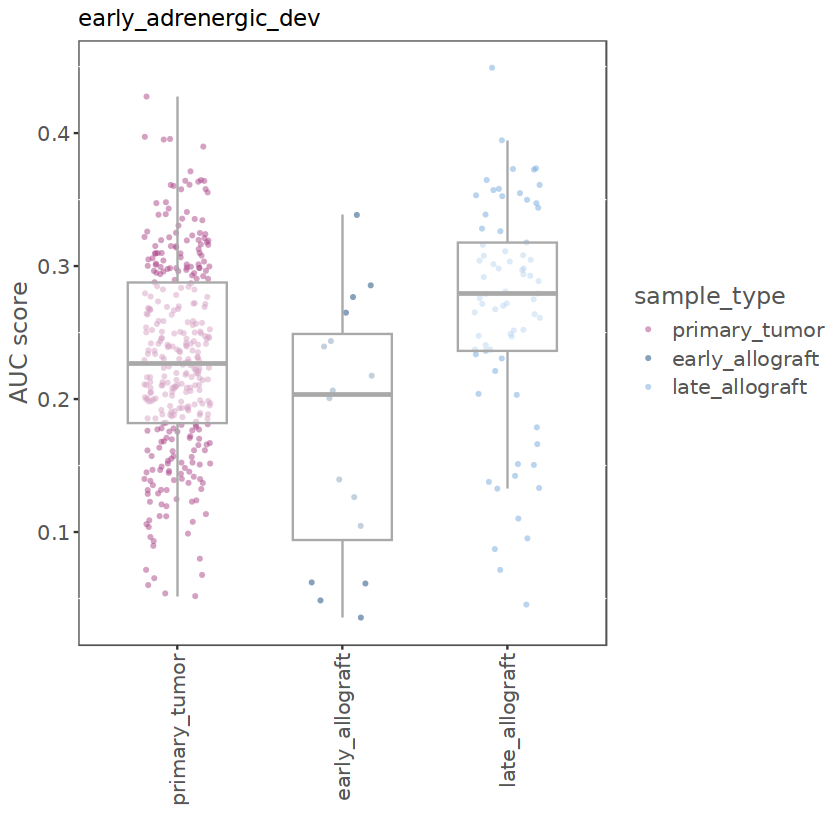

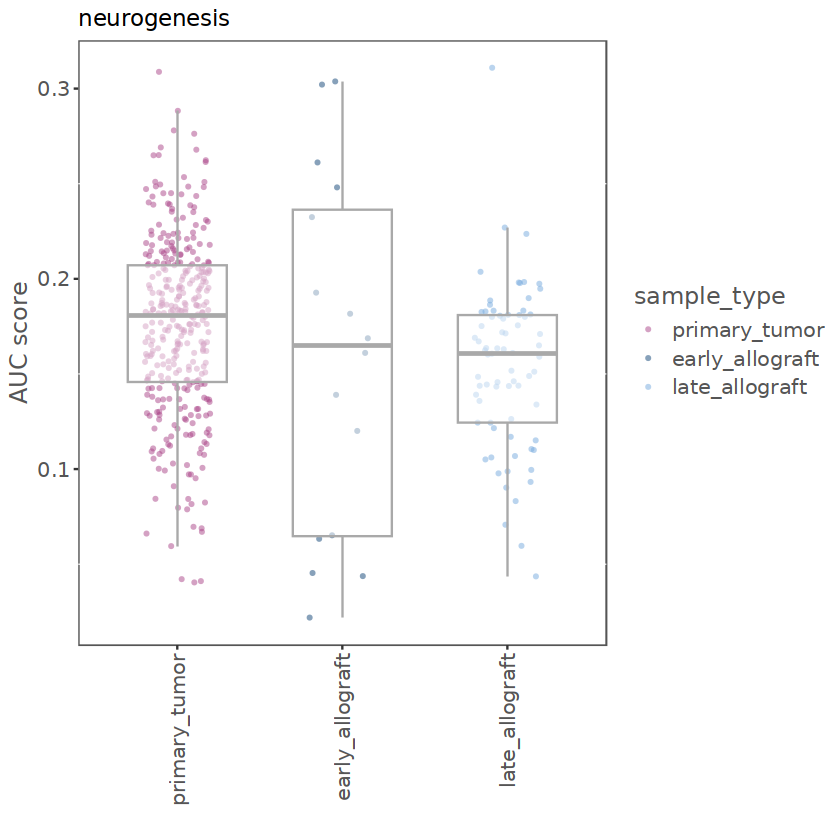

In [40]:
# Per clone in all timepoints
samples_to_plot <- freqs_clones

#for(i in 1:length(samples_to_plot)){
for(i in c(1,3)){

# Get the sub data set
    sample_name <- samples_to_plot[i]

    Idents(dat) <- 'clone_all_tps'

    sub <- subset(dat, idents = sample_name)

# Stop, if the sample contains less than 25 cells    
    if(ncol(sub) < 25){
        next
    }

# Process the sub data set to get clusters and UMAP-coordinates
    print(paste0('Working on dataset: ',sample_name))
    print(paste0('Number of cells: ',ncol(sub)))

    all.genes <- rownames(x = sub)
    sub <- ScaleData(object = sub, features = all.genes)
    sub <- FindVariableFeatures(object = sub,selection.method = 'vst', nfeatures = 1500)

    if(ncol(sub) < 50){
        sub <- RunPCA(object = sub, features = VariableFeatures(object = sub), npcs = 20, verbose = F)
        ndims <- 15
    }else if(ncol(sub) < 120){
        sub <- RunPCA(object = sub, features = VariableFeatures(object = sub), npcs = 30, verbose = F)
        ndims <- 20
    }else{
        sub <- RunPCA(object = sub, features = VariableFeatures(object = sub), npcs = 60, verbose = F)
        ndims <- 25
    }


    # Clustering
    k <- round(max(20,sqrt(ncol(sub)))/4)
    if(k %% 2 == 0) {k <- k+1}
    if(k > 41) {k <- 41}

    sub <- FindNeighbors(object = sub, dims = 1:ndims, k.param = k, verbose = F)
    sub <- FindClusters(object = sub, resolution = 0.4, verbose = F)

    sub <- RunUMAP(sub, reduction = "pca", dims = 1:ndims, n.components = 2, verbose = F, n.neighbors = k)

     
 # Summarise very small groups of cells
    samp_freqs <- as.data.frame(table(sub$sample_sum))
    
    if('multi_seq_07' %in% unique(sub$dataset)){
        
        samp_freqs <- as.character(samp_freqs$Var1[samp_freqs$Freq >= 10])

    }else if('multi_seq_09' %in% unique(sub$dataset)){
        
        samp_freqs <- as.character(samp_freqs$Var1[samp_freqs$Freq >= 8])

    }

    sub$sample_broad <- sub$sample_sum
    sub$sample_broad[(!sub$sample_broad %in% samp_freqs) & sub$sample_type == 'primary_tumor'] <- 'small_sites_PT'
    sub$sample_broad[(!sub$sample_broad %in% samp_freqs) & sub$sample_type == 'early_allograft'] <- 'small_sites_earlyAllo'
    sub$sample_broad[(!sub$sample_broad %in% samp_freqs) & sub$sample_type == 'late_allograft'] <- 'small_sites_lateAllo'
    
    sub$sample_broad <- factor(as.character(sub$sample_broad),
                              levels = unique(c(sub$sample_broad[sub$sample_broad %like any% c('MYCN%')],
                                         sub$sample_broad[sub$sample_broad %like any% c('early%')],
                                         sub$sample_broad[sub$sample_broad %like any% c('small_sites_e%')],
                                         sub$sample_broad[sub$sample_broad %like any% c('late%')],
                                         sub$sample_broad[sub$sample_broad %like any% c('small_sites_l%')]))
                              )
    
# set plotting factors
    sub@meta.data$sample_type <- factor(as.character(sub@meta.data$sample_type),
                                        levels = c('primary_tumor','early_allograft','late_allograft')
                                        )

    sub@meta.data$sample_ID <- factor(as.character(sub@meta.data$sample_ID),
                                        levels = c(unique(sub@meta.data$sample_all[!sub@meta.data$sample_all %like any% c('early%','late%')]),
                                                   unique(sub@meta.data$sample_all[sub@meta.data$sample_all %like any% c('early%')]),
                                                   unique(sub@meta.data$sample_all[sub@meta.data$sample_all %like any% c('late%')]))
                                        )
    sub@meta.data$sample_sum <- as.character(sub@meta.data$sample_sum)
    sub@meta.data$sample_sum <- factor(as.character(sub@meta.data$sample_sum),
                                        levels = c(unique(sub@meta.data$sample_sum[!sub@meta.data$sample_sum %like any% c('early%','late%')]),
                                                   unique(sub@meta.data$sample_sum[sub@meta.data$sample_sum %like any% c('early%')]),
                                                   unique(sub@meta.data$sample_sum[sub@meta.data$sample_sum %like any% c('late%')]))
                                        )
# plot UMAPS

    print(
    DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "sample_type", dims = c(1,2), cols = tol21rainbow[c(2,4,6,13,15,16,18,20,10,12,22,24,26,28,29,30,31,32,33,21,23,2,8)], order = T, na.value="light grey") +
                 NoAxes() +
                 mytheme_angledYtitle
    )

    print(
        DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "sample_broad", dims = c(1,2), cols = tol21rainbow[c(2,4,6,13,15,16,18,20,10,12,22,24,26,28,29,30,31,32,33,21,23,2,8)], order = T, na.value="light grey") +
                 NoAxes() +
                 mytheme_angledYtitle
    )

    print(
    DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "location", dims = c(1,2), cols = tol21rainbow[c(2,4,6,13,15,16,18,20,10,12,22,24,26,28,29,30,31,32,33,21,23,2,8)], shuffle = T, na.value="light grey") +
                 NoAxes() +
                 mytheme_angledYtitle
    )

    print(
        DimPlot(object = sub, reduction = 'umap', pt.size = 1, group.by = "seurat_clusters", dims = c(1,2), cols = blues_24[2:length(blues_24)], label = T, label.size = 5, shuffle = T, na.value="light grey") +
                 NoAxes() +
                 mytheme_angledYtitle
    )
    
# plot score boxes for timepoints and modules
print('Plotting module score boxplots')

#    for(j in 1:length(set_all)){
    for(j in 1:2){
        print(
            ggplot(sub@meta.data, aes(x = sample_type, y = sub@meta.data[,set_all[j]]), verbose = F) +
                    geom_jitter(size = 1.1, width = 0.2, height = 0, aes(col = sample_type, fill = sample_type), shape=16, alpha = 0.5) +
                    geom_boxplot(width = 0.6, outlier.shape = NA, alpha = 0.5, color = 'dark grey') +
                    scale_color_manual(values=c(tol21rainbow[c(2,4,6,7,9,10,12,13,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,2)][1:length(unique(sub@meta.data$sample_type))])) +
                    scale_fill_manual(values=alpha(c(tol21rainbow[c(2,4,6,7,9,10,12,13,15,16,18,20,22,24,26,28,29,30,31,32,33,21,23,2)][1:length(unique(sub@meta.data$sample_type))]),0.4)) +
                    labs(title = module_metnames[j], y = 'AUC score', x = '') +
                    mytheme_angledX
        )
    }

}

## Module expression fractions in clones and timepoints

In [16]:
# Load Seurat metadata with high-resolution clone assignments and module scores
dat <- readRDS('./data/seur_obj_allmerged_final_NB_with_clones_and_scores_withLowResClones.rds')

# Remove cells that have not been assigned to a clone
cells_keep <- rownames(dat@meta.data[!is.na(dat@meta.data$clone_all_tps),])
dim(dat)
dat <- subset(dat, cells = cells_keep)
dim(dat)

[1] 26338 57601

[1] 26338 25970

In [17]:
# Load final module table
modules_pan <- read.delim('../gene_modules/final_gene_modules_list.csv', sep = ',', stringsAsFactors = F, header = T)

# Re-format into list
modules_pan <- as.list(modules_pan)

# Double-check that common gene names contain correct set of special characters
modules_pan <- lapply(modules_pan, function(x) gsub("si\\.","si:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("zgc\\.","zgc:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("mt\\.","mt-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("dkey\\.","dkey-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("h211\\.","h211-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("ch73\\.","ch73-",x))

# Remove empty entries
modules_pan <- lapply(modules_pan, function(x) {
  # Remove NA and empty string "" entries
  x[!(is.na(x) | x == "")]
})

# Remove modules that are too short
modules_pan <- modules_pan[lengths(modules_pan) > 5]

In [30]:
# Get order of modules in data
mod_order <- read.delim('data/mod_name_order_in_data_allTPs.csv', sep = ',', stringsAsFactors = F, header = T, row.names = 1)
mod_order <- mod_order$x

In [18]:
# Subset for cells from one allografting experiment
Idents(dat) <- 'dataset'

sub_dat_name <- 'dataset_bA4'
dat <- subset(dat, idents = c('multi_seq_09','multi_seq_16','multi_seq_18','multi_seq_19'))

#sub_dat_name <- 'dataset_bA2'
#dat <- subset(dat, idents = c('multi_seq_07','multi_seq_13','multi_seq_14'))

In [19]:
# Process data
all.genes <- rownames(x = dat)
dat <- ScaleData(object = dat, features = all.genes)

Centering and scaling data matrix



In [20]:
# Find variable genes and remove those that were found to be batch-effect associated

# Load genes associated with the cell cycle that should also be excluded for clustering
to.regress.cellcycle <- read.csv("../transcriptome_analysis/zfish_prolif_markers.csv")
to.regress.cellcycle <- as.character(to.regress.cellcycle$x)

regress_blood <- c("hbba1","hbba1.1","hbae1","hbbe2","hbbe1.1","lyz","lect2l","mmp9","cd74a","cd74b","c1qb","c1qc")

dat <- FindVariableFeatures(object = dat,selection.method = 'vst', nfeatures = 2000)

var_feats <- VariableFeatures(object = dat)
var_feats <- var_feats[!var_feats %in% c("mCherry", "EGFP","MYCN", "LMO1", "BIRC5","dTomato")]
var_feats <- var_feats[!var_feats %in% to.regress.cellcycle]
var_feats <- var_feats[!var_feats %in% regress_blood]

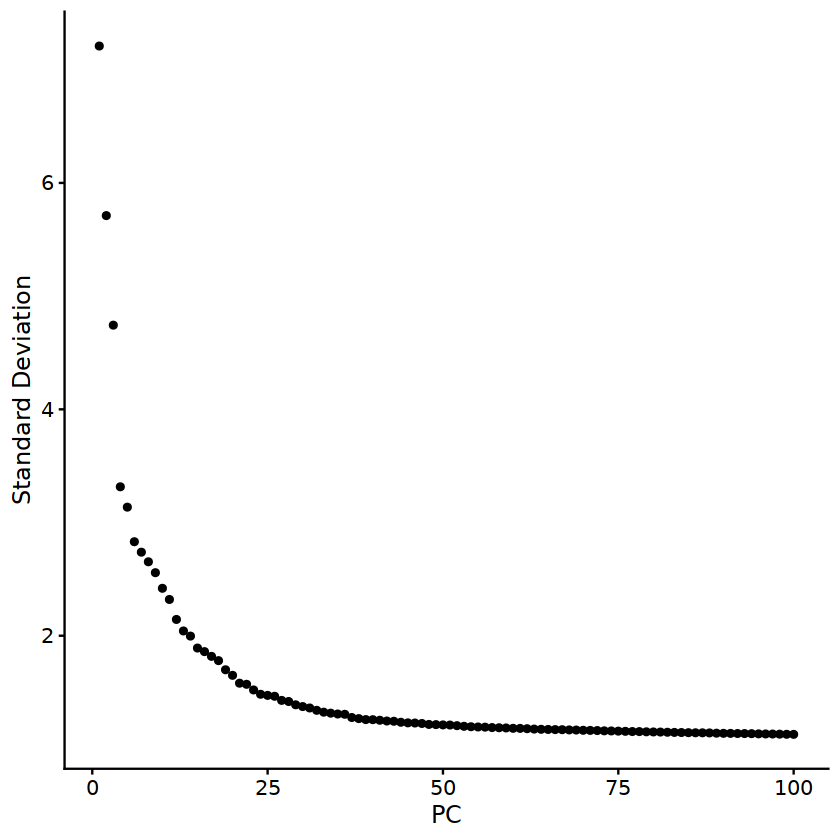

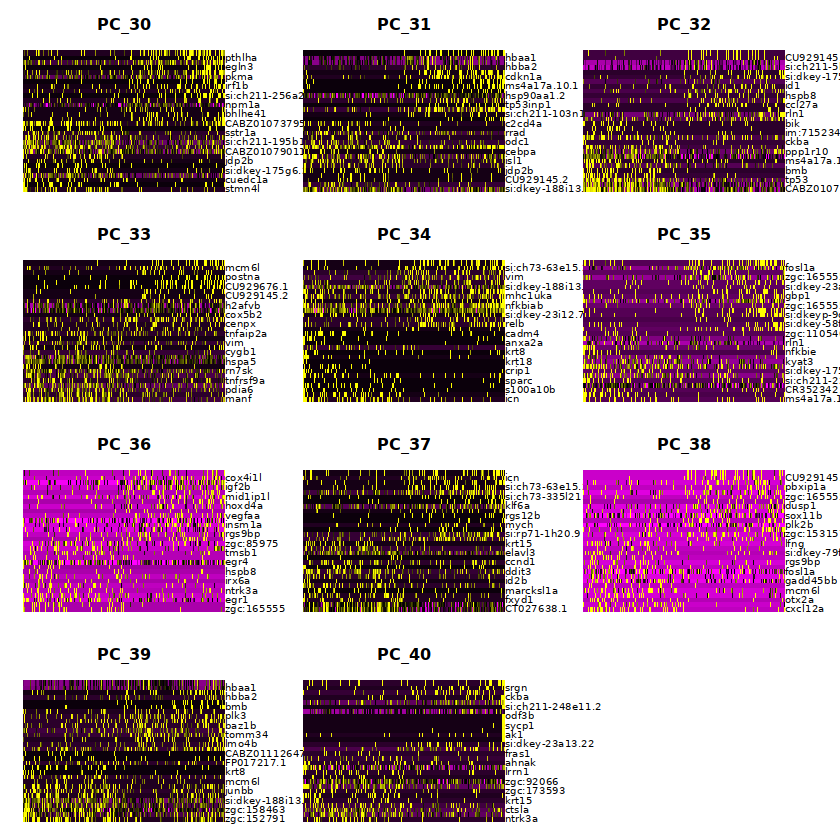

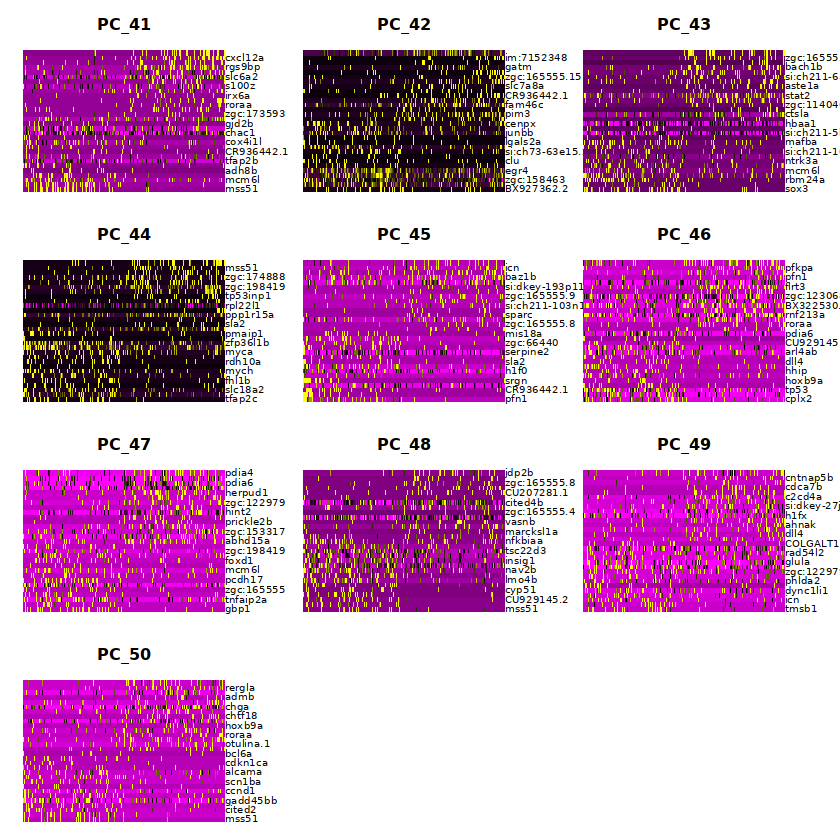

In [21]:
# PCA
dat <- RunPCA(dat, features = var_feats, npcs= 100, verbose = FALSE)

# elbow plot
ElbowPlot(object = dat, ndims = 100)
DimHeatmap(object = dat, dims = 30:40, cells = 500, balanced = TRUE)
DimHeatmap(object = dat, dims = 41:50, cells = 500, balanced = TRUE)

In [22]:
# Cluster, UMAP, TSNE
ndims <- 40

# Clustering
k <- round(max(20,sqrt(ncol(dat)))/4)
if(k %% 2 == 0) {k <- k+1}
if(k > 41) {k <- 41}

dat <- FindNeighbors(object = dat, dims = 1:ndims, k.param = k)
dat <- FindClusters(object = dat, resolution = 1.4)
dat <- RunUMAP(dat, reduction = "pca", dims = 1:ndims)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 13113
Number of edges: 898483

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8664
Number of communities: 22
Elapsed time: 2 seconds


10:40:14 UMAP embedding parameters a = 0.9922 b = 1.112

10:40:14 Read 13113 rows and found 40 numeric columns

10:40:14 Using Annoy for neighbor search, n_neighbors = 30

10:40:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:40:17 Writing NN index file to temp file /tmp/RtmpwUMdr9/filee9592cc703d4

10:40:17 Searching Annoy index using 1 thread, search_k = 3000

10:40:22 Annoy recall = 100%

10:40:23 Commencing smooth kNN distance calibration using 1 thread

10:40:25 Initializing from normalized Laplacian + noise

10:40:25 Commencing optimization for 200 epochs, with 580234 positive edges

10:40:48 Optimization finished



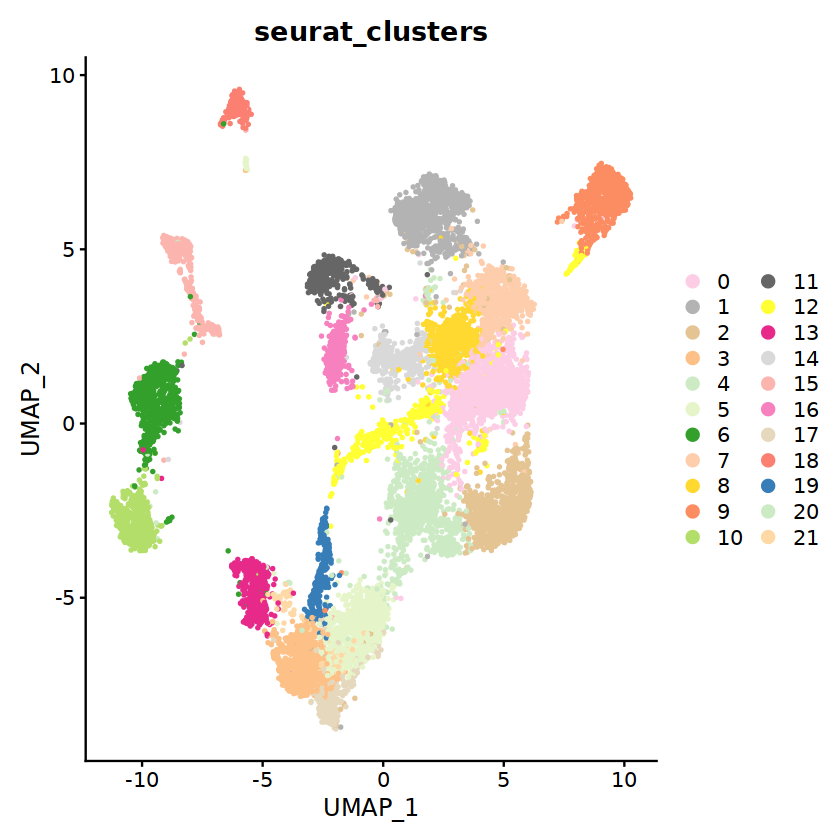

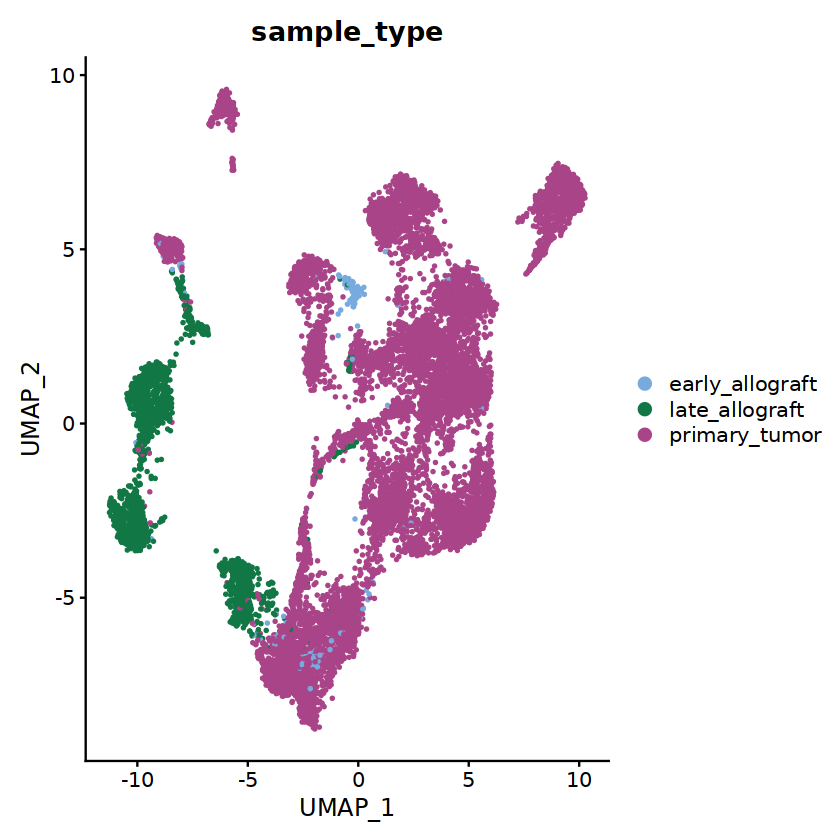

In [23]:
# Plot
n <- length(unique(dat@meta.data$seurat_clusters))
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector_det = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
col_vector_det=sample(col_vector_det, n)

DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "seurat_clusters", cols = col_vector_det, shuffle = T)

DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "sample_type", cols = tol21rainbow[c(6,10,2)], shuffle = T)

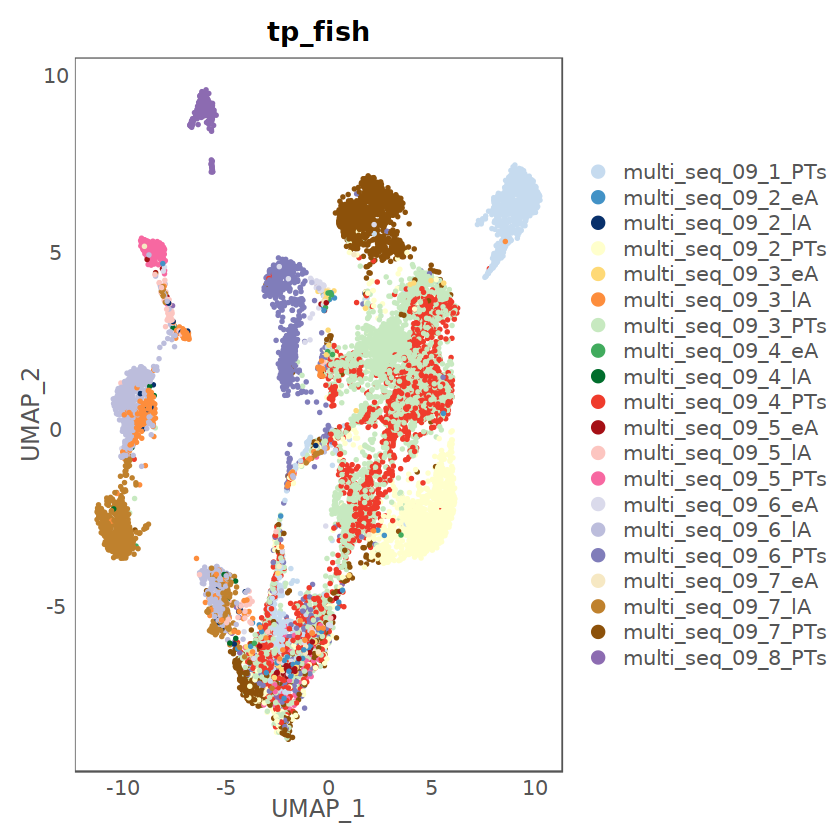

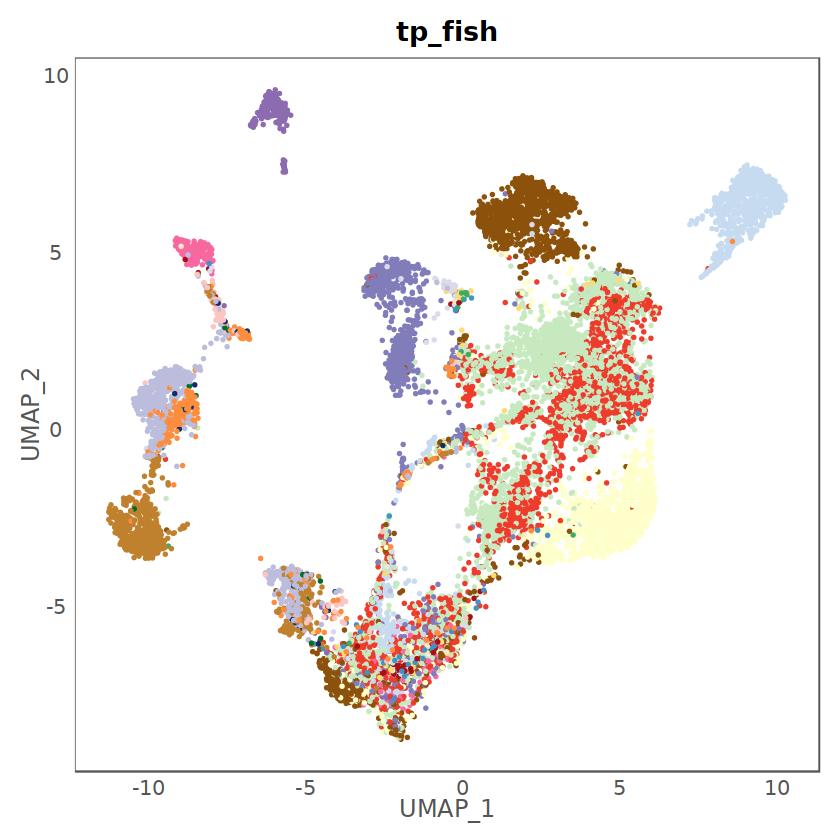

In [25]:
# Plot fish assignments on UMAP
# For bAllos2
#dat@meta.data$clone_all_tps <- gsub('multi_seq_14_','',dat@meta.data$clone_all_tps)
#dat@meta.data$clone_all_tps <- gsub('multi_seq_13_','',dat@meta.data$clone_all_tps)
#dat@meta.data$clone_all_tps <- gsub('multi_seq_07_','',dat@meta.data$clone_all_tps)

dat@meta.data$clone_all_tps <- gsub('multi_seq_09_','',dat@meta.data$clone_all_tps)
dat@meta.data$clone_all_tps <- gsub('multi_seq_16_','',dat@meta.data$clone_all_tps)
dat@meta.data$clone_all_tps <- gsub('multi_seq_18_','',dat@meta.data$clone_all_tps)
dat@meta.data$clone_all_tps <- gsub('multi_seq_19_','',dat@meta.data$clone_all_tps)

pal_clones <- c(
brewer.pal(9, 'Blues')[c(3,6,9)],
brewer.pal(9, 'YlOrRd')[c(1,3,5)],
brewer.pal(9, 'Greens')[c(3,6,8)],
brewer.pal(9, 'Reds')[c(6,8)],
brewer.pal(9, 'RdPu')[c(3,5)],
brewer.pal(9, 'Purples')[c(3,4,6)],
rev(brewer.pal(9, 'BrBG'))[c(6,8,9)],
brewer.pal(9, 'BuPu')[c(6,8)],
'light grey'
)

dat@meta.data$tp_fish <- as.character(dat@meta.data$tp_fish)
dat@meta.data$tp_fish <- factor(dat@meta.data$tp_fish, levels = c(sort(unique(dat@meta.data$tp_fish[dat@meta.data$tp_fish != 'NA'])),
                                                                 NA))

DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "tp_fish", cols = pal_clones) +
                 NoAxes() +
                 mytheme_angledYtitle

DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "tp_fish", cols = pal_clones) +
                 NoAxes() +
                 NoLegend() +
                 mytheme_angledYtitle

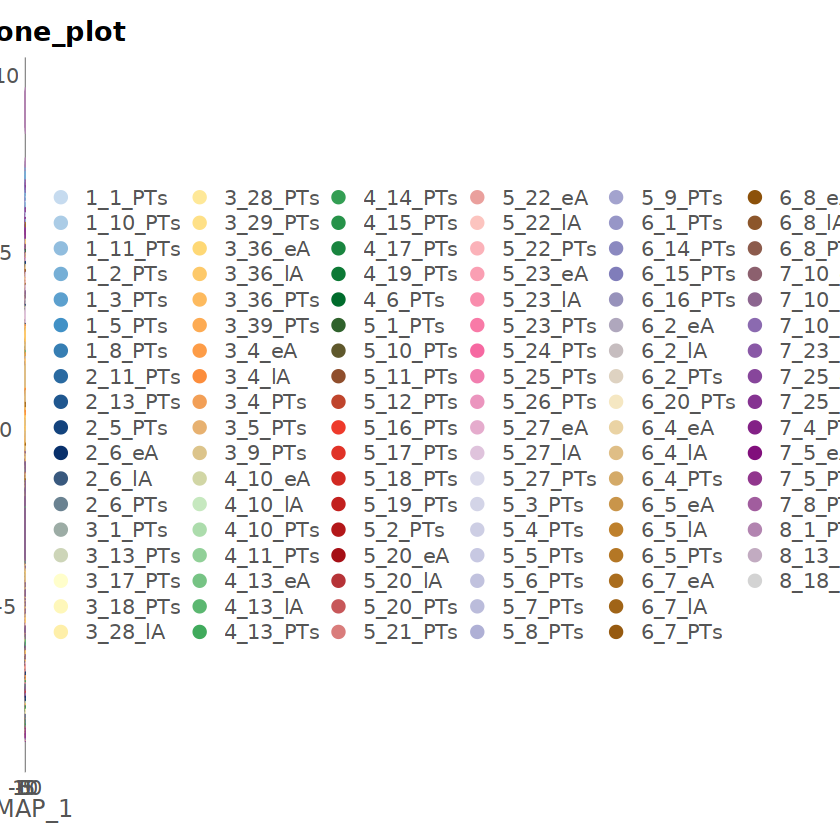

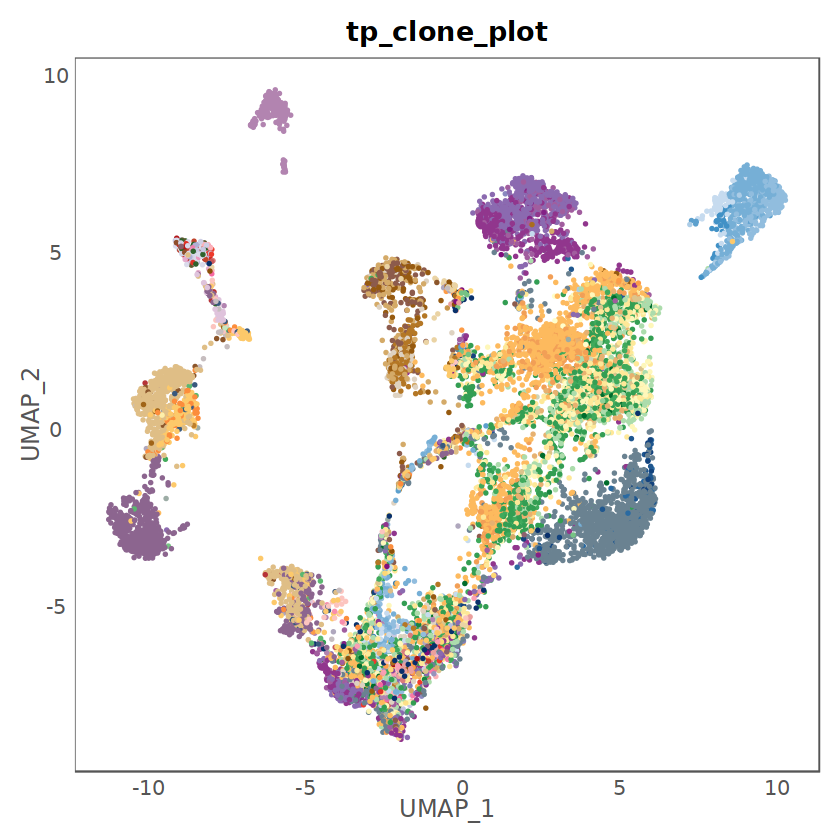

In [26]:
# Plot clone assignments on UMAP
dat@meta.data$tp_clone <- paste0(dat@meta.data$clone_all_tps, '_',dat@meta.data$sample_type_short)
dat@meta.data$tp_clone[dat@meta.data$tp_clone %like any% 'NA%'] <- 'NA'

# Remove very small clones from plot
clone_size <- as.data.frame(table(dat@meta.data$tp_clone))
clone_size <- clone_size[clone_size$Freq < 5,]
dat@meta.data$tp_clone_plot <- dat@meta.data$tp_clone
dat@meta.data$tp_clone_plot[dat@meta.data$tp_clone_plot %in% clone_size] <- NA

pal_clones_large <- colorRampPalette(pal_clones)(length(unique(dat@meta.data$tp_clone_plot)))

DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "tp_clone_plot", cols = pal_clones_large) +
                 NoAxes() +
                 mytheme_angledYtitle

DimPlot(object = dat, reduction = 'umap', pt.size = 0.5, group.by = "tp_clone_plot", cols = pal_clones_large) +
                 NoAxes() +
                 NoLegend() +
                 mytheme_angledYtitle

### Subset for clone of interest and plot module fractions

**Interesting clones**:   
bAllos 2  
1. 1_3
2. 3_2
3. 6_7 (no PT cells)
  
bAllos 4  
1. 3_36
2. 6_4
3. 7_10

In [31]:
clone_select <- '3_36'

In [32]:
metadat_int <- dat@meta.data

metadat_int$clone_all_tps_na <- metadat_int$clone_all_tps
metadat_int$clone_all_tps_na[is.na(metadat_int$clone_all_tps_na)] <- 'no_clone'

metadat_sub <- metadat_int[metadat_int$clone_all_tps_na == clone_select,]
dim(metadat_sub)

[1] 1698  192

#### Calculate fractions per timepoint per module
Plot all modules

In [33]:
# Calculate fraction of cells that express each module
metadat <- metadat_sub
tums <- metadat[duplicated(metadat$sample_type) == F, c("tp_fish","clone_all_tps_na","tumor_id","genotype","sample_ID","location","sex","dissociation","fish_id", "orig.ident","ct_final",'dataset','sample_type')]
mod_names <- paste0('barkley_',mod_order)

for(l in 1:length(mod_names)){

    mod_name <- mod_names[l]

    metadat_it <- metadat
    names(metadat_it)[names(metadat_it) == mod_name] <- "mod_name"
    metadat_it$mod_pres <- "no"
    metadat_it$mod_pres[metadat_it$mod_name > 0.5] <- "yes"    

    tums$ModFrac <- NA

        for(i in 1:length(unique(tums$sample_type))){

            tum <- unique(tums$sample_type)[i]
            tum_dat <- metadat_it[metadat_it$sample_type == tum,]

            frac_yes <- nrow(tum_dat[tum_dat$mod_pres == "yes",])

            tums$ModFrac[tums$sample_type == tum] <- frac_yes/nrow(tum_dat)
        }

    names(tums)[names(tums) == 'ModFrac'] <- mod_names[l]
    
}

In [34]:
# Transform dataframe for plotting
tums <- tums[,c('sample_type',mod_names)]
rownames(tums) <- tums$sample_type
tums$sample_type <- NULL
tums <- as.data.frame(t(tums))

tums$process <- rownames(tums)
long_tums <- tums %>%
  pivot_longer(cols = c(primary_tumor, early_allograft, late_allograft),
               names_to = "Condition", 
               values_to = "Value") %>%
  # Preserve the 'Process' column
  mutate(process = as.character(process))

In [35]:
long_tums$process <- gsub('barkley_','',long_tums$process)
long_tums_allomods <- long_tums[long_tums$process %like any% c('lAs%','eAs%'),]
long_tums_ptmods <- long_tums[!long_tums$process %like any% c('lAs%','eAs%'),]
long_tums_ptmods <- long_tums_ptmods[long_tums_ptmods$process %in% names(modules_pan),]

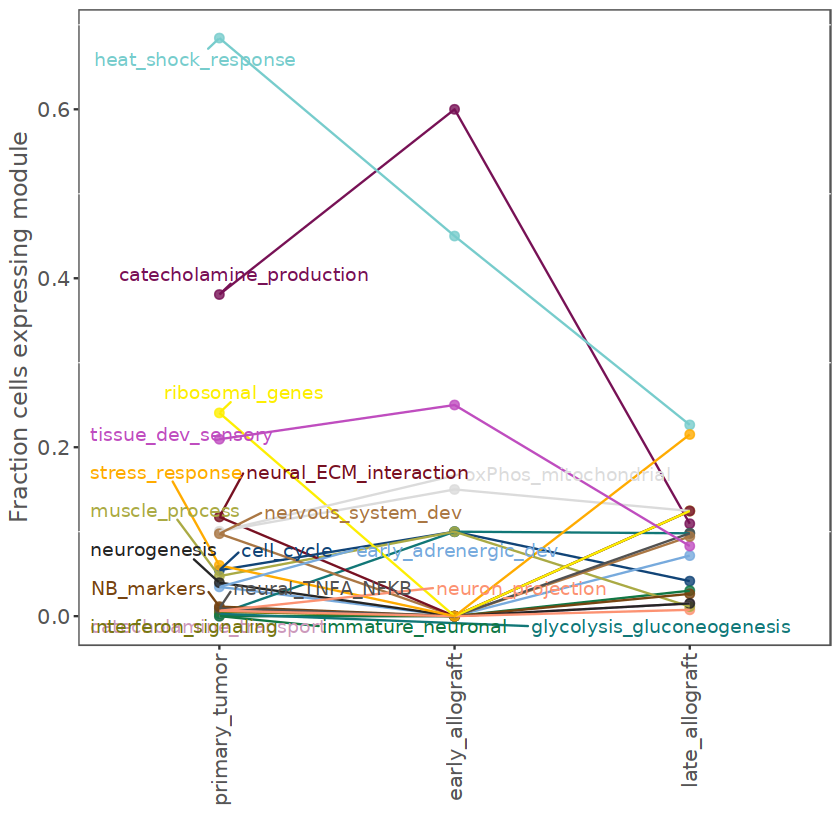

In [36]:
long_tums_ptmods$process <- as.character(long_tums_ptmods$process)
long_tums_ptmods$Condition <- as.character(long_tums_ptmods$Condition)
long_tums_ptmods$Condition <- factor(long_tums_ptmods$Condition, levels = c('primary_tumor','early_allograft','late_allograft'))

    ggplot(long_tums_ptmods, aes(x = Condition, y = Value, fill = Condition, col = process)) +
            geom_point(alpha = 0.8, size = 2) +
            geom_line(aes(group = process)) +
            scale_color_manual(values = tol21rainbow[c(1,3,4,6,7,9,10,13,14,16,17,19,22,24,26,28,29,30,32)]) +
            ylab(paste0("Fraction cells expressing module")) +
            xlab('') +
            theme(legend.position = 'none') +
            mytheme_angledX +
            geom_text_repel(
                data = long_tums_ptmods %>% 
                    group_by(process) %>% 
                    filter(Condition == 'primary_tumor'),
                aes(label = process),
                box.padding = 0.5, max.overlaps = 400
            )


#### Plot fractions across individual timepoints and late graft locations

In [37]:
metadat_int <- dat@meta.data

metadat_int$clone_all_tps_na <- metadat_int$clone_all_tps
metadat_int$clone_all_tps_na[is.na(metadat_int$clone_all_tps_na)] <- 'no_clone'


In [38]:
# First remove the ambiguous and wildytpe / no clone cells
metadat <- metadat_int
metadat <- metadat[!metadat$clone_all_tps %in% c('ambiguous_linBC','fish_def_linBC','wildtype','NA'),]
metadat <- metadat[!is.na(metadat$clone_all_tps),]

metadat$tumor_clone <- paste0(metadat$sample_ID,'_',metadat$clone_all_tps)
metadat$tumor_clone[metadat$tumor_clone %like any% 'early%'] <- paste0('early_allos_', metadat$clone_all_tps[metadat$tumor_clone %like any% 'early%'])

# sum clones with less than 8 cells
clonal_sizes <- as.data.frame(table(metadat$tumor_clone))

clonal_sizes <- as.character(clonal_sizes$Var1[clonal_sizes$Freq < 10])

metadat$sample_sum <- metadat$sample_ID
metadat$tumor_clone[metadat$tumor_clone %in% clonal_sizes] <- paste0('small_clones_',metadat$sample_type[metadat$tumor_clone %in% clonal_sizes])


In [39]:
# Calculate fraction of cells that express each module
tums <- metadat[duplicated(metadat$tumor_clone) == F, c("tumor_clone","tp_clone","tp_fish","clone_all_tps","clone_all_tps_na","tumor_id","genotype","sample_ID","location","sex","dissociation","fish_id", "orig.ident","ct_final",'dataset','sample_type')]

mod_names <- mod_names

for(l in 1:length(mod_names)){

mod_name <- mod_names[l]

metadat_it <- metadat
names(metadat_it)[names(metadat_it) == mod_name] <- "mod_name"
metadat_it$mod_pres <- "no"
metadat_it$mod_pres[metadat_it$mod_name > 0.5] <- "yes"    

tums$ModFrac <- NA

    for(i in 1:length(unique(tums$tumor_clone))){

        tum <- unique(tums$tumor_clone)[i]
        tum_dat <- metadat_it[metadat_it$tumor_clone == tum,]

        frac_yes <- nrow(tum_dat[tum_dat$mod_pres == "yes",])

        tums$ModFrac[tums$tumor_clone == tum] <- frac_yes/nrow(tum_dat)
    }
    
    names(tums)[names(tums) == 'ModFrac'] <- mod_names[l]
    
}

In [40]:
# Prepare dataframe for plotting
tums <- tums[,c('tumor_clone','clone_all_tps',mod_names)]
rownames(tums) <- tums$tumor_clone
tums$tumor_clone <- NULL

tums$Condition <- rownames(tums)
tums$sample_type <- 'late_allos'
tums$sample_type[tums$Condition %like any% 'MYCN_%'] <- 'primary_tumor'
tums$sample_type[tums$Condition %like any% 'early%'] <- 'early_allos'

tums$prio <- 'background'

tums$prio[tums$clone_all_tps == clone_select] <- clone_select
clone_plot <- clone_select


In [43]:
tums$sample_type <- as.character(tums$sample_type)
tums$sample_type[tums$sample_type == 'early_allos'] <- 'early_allografts'
tums$sample_type[tums$sample_type == 'late_allos'] <- 'late_allografts'

tums$sample_type <- factor(as.character(tums$sample_type), levels = c('primary_tumor','early_allografts','late_allografts'))


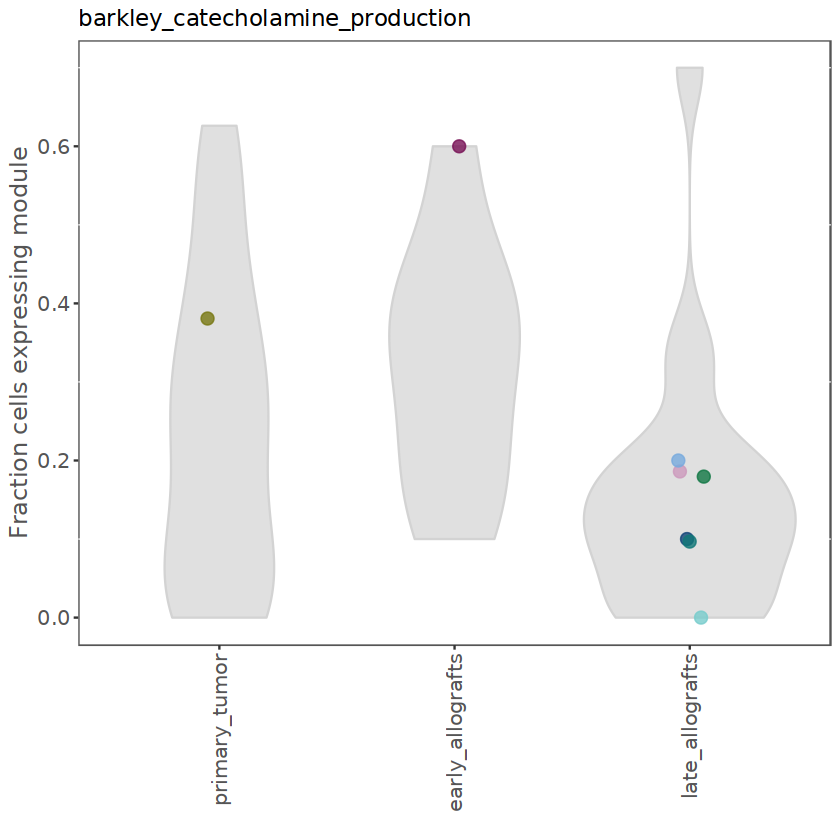

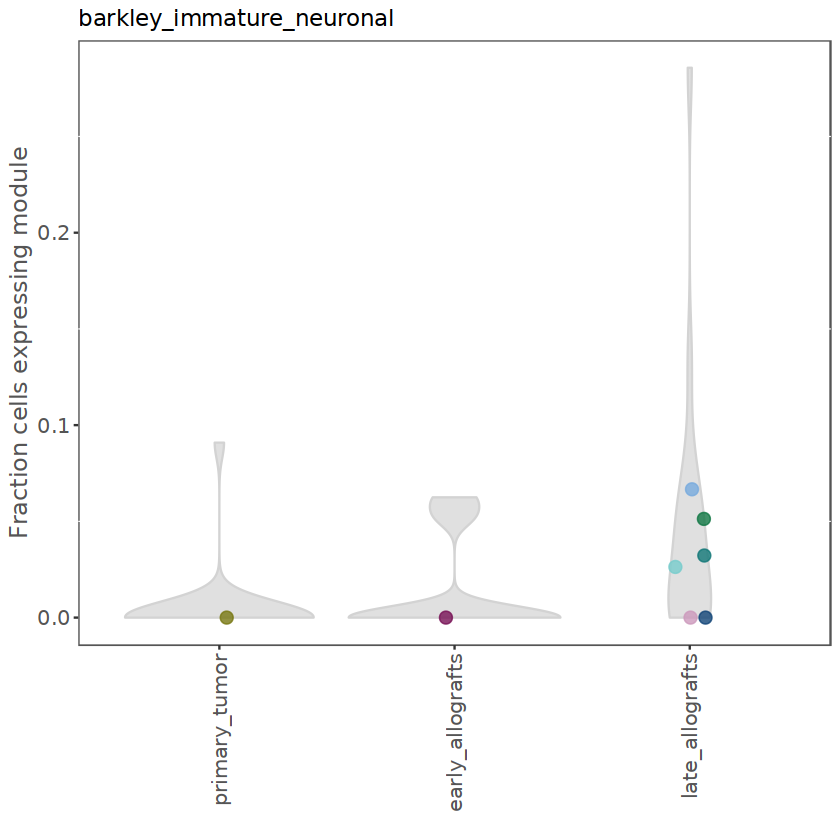

In [44]:
mod_name <- paste0('barkley_','catecholamine_production')

tums_plot <- tums
names(tums_plot)[names(tums_plot) == mod_name] <- "mod_it"
tums_plot$sample_type <- factor(tums_plot$sample_type, levels=c("primary_tumor", "early_allografts", "late_allografts"))

ggplot(tums_plot, aes(x = sample_type, y = mod_it, fill = Condition)) +
       geom_violin(fill = 'light grey', color = 'light grey', alpha = 0.7) +
        geom_point(position = position_jitter(width = 0.08, height = 0), alpha = 0.8, size = 3, data = subset(tums_plot, prio == clone_plot), aes(col = Condition)) +
        scale_color_manual(values = tol21rainbow[c(1,3,4,6,7,9,10,13,14,16,22,24,26,28,29,30,32)]) +
        labs(x = '', y = 'Fraction cells expressing module',title = mod_name) +
                theme(legend.position = 'none') +
                mytheme_angledX
    

mod_name <- paste0('barkley_','immature_neuronal')

tums_plot <- tums
names(tums_plot)[names(tums_plot) == mod_name] <- "mod_it"
tums_plot$sample_type <- factor(tums_plot$sample_type, levels=c("primary_tumor", "early_allografts", "late_allografts"))

ggplot(tums_plot, aes(x = sample_type, y = mod_it, fill = Condition)) +
       geom_violin(fill = 'light grey', color = 'light grey', alpha = 0.7) +
        geom_point(position = position_jitter(width = 0.08, height = 0), alpha = 0.8, size = 3, data = subset(tums_plot, prio == clone_plot), aes(col = Condition)) +
        scale_color_manual(values = tol21rainbow[c(1,3,4,6,7,9,10,13,14,16,22,24,26,28,29,30,32)]) +
        labs(x = '', y = 'Fraction cells expressing module',title = mod_name) +
                theme(legend.position = 'none') +
                mytheme_angledX
    

## Calculate differential module expression between timepoints

### Reload and prepare data

In [4]:
# Load Seurat metadata with high-resolution clone assignments and module scores
dat <- readRDS('./data/seur_obj_allmerged_final_NB_with_clones_and_scores_withLowResClones.rds')

# Remove cells that have not been assigned to a clone
cells_keep <- rownames(dat@meta.data[!is.na(dat@meta.data$clone_all_tps),])
dim(dat)
dat <- subset(dat, cells = cells_keep)
dim(dat)


[1] 26338 57601

[1] 26338 25970

In [2]:
# Load final module table
modules_pan <- read.delim('../gene_modules/final_gene_modules_list.csv', sep = ',', stringsAsFactors = F, header = T)

# Re-format into list
modules_pan <- as.list(modules_pan)

# Double-check that common gene names contain correct set of special characters
modules_pan <- lapply(modules_pan, function(x) gsub("si\\.","si:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("zgc\\.","zgc:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("mt\\.","mt-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("dkey\\.","dkey-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("h211\\.","h211-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("ch73\\.","ch73-",x))

# Remove empty entries
modules_pan <- lapply(modules_pan, function(x) {
  # Remove NA and empty string "" entries
  x[!(is.na(x) | x == "")]
})

# Remove modules that are too short
modules_pan <- modules_pan[lengths(modules_pan) > 5]

In [3]:
# Get order of modules in data
mod_order <- read.delim('data/mod_name_order_in_data_allTPs.csv', sep = ',', stringsAsFactors = F, header = T, row.names = 1)
mod_order <- mod_order$x

In [5]:
# Add proper naming column covering all subclones to metadata

dat@meta.data$dataset_timepoint_clones <- 'none'
dat@meta.data$dataset_timepoint_clones <- paste0(dat@meta.data$clone_all_tps,'_',dat@meta.data$sample_type)

# Add a sample-clone identifier, in which early allograft cells are grouped by experiment (instead of per larval batch) and clone.
dat@meta.data$sample_sum <- dat@meta.data$sample_ID
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b1%'] <- 'early_allos_b1'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b2%'] <- 'early_allos_b2'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b3%'] <- 'early_allos_b3'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b4%'] <- 'early_allos_b4'

dat@meta.data$tumorsample_clone <- paste0(dat@meta.data$sample_sum,'_',dat@meta.data$clone_all_tps)

# Remove cells that were not assigned to a clone
dat@meta.data$rem <- 'keep'
dat@meta.data$rem[is.na(dat@meta.data$clone_all_tps)] <- 'remove'

Idents(dat) <- 'rem'
dat <- subset(dat, idents = 'keep')
dim(dat)

[1] 26338 25970

In [10]:
# remove very small clones
samps_tums <- as.data.frame(table(dat@meta.data$tumorsample_clone))
colnames(samps_tums) <- c('tumorsample_clone','Freq')
samps_tums <- samps_tums[samps_tums$Freq >= 10,]

# Get cell IDs to subset for
cell_id_vec_others <- rownames(dat@meta.data[dat@meta.data$tumorsample_clone %in% samps_tums$tumorsample_clone,])

# subset data
dat <- subset(dat, cells = cell_id_vec_others)
dim(dat)

[1] 26338 25186

### Run diff expression test

**Get a list of all possible pairwise clone-sample-type combinations to loop through.**

In [12]:
# Define the list of clones
clone_list <- unique(dat$tumorsample_clone)

# Generate all possible combinations of two elements
combinations <- combn(clone_list, 2, simplify = FALSE)

# Filter and exclude unwanted combinations
filtered_combinations <- lapply(combinations, function(x) {
  # Sort the elements in the combination
  sorted_combination <- sort(x)
  
  # Only keep the combination if it's not the same element and not a duplicated combination
  if (length(unique(x)) == 2 && !any(duplicated(sorted_combination))) {
    return(x)
  }
})

# Remove NULL entries (combinations to be excluded)
filtered_combinations <- Filter(Negate(is.null), filtered_combinations)

# Convert the result into a dataframe
combinations_df <- as.data.frame(t(do.call(cbind, filtered_combinations)))
colnames(combinations_df) <- c("Element1", "Element2")

rownames(combinations_df) <- paste0('it_',rownames(combinations_df))

In [13]:
head(combinations_df)


Element1                             
it_1 MYCN_LMO1_lat_m6_2_1_multi_seq_06_3_3
it_2 MYCN_LMO1_lat_m6_2_1_multi_seq_06_3_3
it_3 MYCN_LMO1_lat_m6_2_1_multi_seq_06_3_3
it_4 MYCN_LMO1_lat_m6_2_1_multi_seq_06_3_3
it_5 MYCN_LMO1_lat_m6_2_1_multi_seq_06_3_3
it_6 MYCN_LMO1_lat_m6_2_1_multi_seq_06_3_3
     Element2                               
it_1 MYCN_LMO1_lat_m6_2_1_multi_seq_06_3_6  
it_2 MYCN_LMO1_vent_m6_2_1_multi_seq_06_3_9 
it_3 MYCN_LMO1_vent_m6_1_multi_seq_06_2_5   
it_4 MYCN_LMO1_vent_m6_2_1_multi_seq_06_3_10
it_5 MYCN_LMO1_vent_m6_2_1_multi_seq_06_3_3 
it_6 MYCN_lat_m6_1_multi_seq_06_1_6

**Run test**

In [16]:
# Run differential expression test.
# Set the type of score to use for the differential expression test.
# Parallelize the loop with mclapply by setting num_cores.
num_cores = 20

b1 <- 1
b2 <- length(mod_order)

type <- 'auc' # barkley, auc or count

module_names <- c(b1:b2)
module_metnames <- mod_order

results_list <- mclapply(rownames(combinations_df), function(f) {
    clone1 <- combinations_df[f,1]
    clone2 <- combinations_df[f,2]

    modScorDiff_faultTol(clone1 = clone1, clone2 = clone2,
                         dat = dat, grouping_var = 'tumorsample_clone',
                         nperm = 1000, type = type,
                         module_names = module_names, module_metnames = module_metnames,
                         size_group_1 = 10, size_group_2 = 10, size_groups_summed = 25
                        )
}, mc.cores = num_cores)

saveRDS(results_list, file = paste0('./data/lowResClone_sublocations_TPs_diff_results_with_perm_scoreType_',type,'_DR_mods.rds'))


In [15]:
# Get module expression stats.
# This should be run with type <- barkley, as these scores are best to determine whether a module is expressed or not.
# Parallelize the loop with mclapply by setting num_cores.
num_cores = 20

b1 <- 1
b2 <- length(mod_order)

type <- 'barkley' # barkley

module_names <- c(b1:b2)
module_metnames <- mod_order

results_list <- mclapply(rownames(combinations_df), function(f) {
    clone1 <- combinations_df[f,1]
    clone2 <- combinations_df[f,2]

    getExpressionStats(clone1 = clone1, clone2 = clone2,
                       dat = dat, grouping_var = 'tumorsample_clone',
                       type = type, module_names = module_names, module_metnames = module_metnames,
                       size_group_1 = 10, size_group_2 = 10, size_groups_summed = 25
                      )
}, mc.cores = num_cores)

saveRDS(results_list, file = paste0('./data/lowResClone_sublocations_TPs_diff_scoreExpressionStats_scoreType_',type,'_DR_mods.rds'))


#### Load results of differential expression test

In [17]:
type <- 'auc' # barkley, auc or count

# Load expression statistics
stats_list <- readRDS('./data/lowResClone_sublocations_TPs_diff_scoreExpressionStats_scoreType_barkley_DR_mods.rds')

# Scores
results_list <- readRDS(paste0('./data/lowResClone_sublocations_TPs_diff_results_with_perm_scoreType_',type,'_DR_mods.rds'))


In [18]:
results_df_p <- sapply(results_list, function(x) x[[1]])
results_df_p <- do.call(rbind,results_df_p)
                          
results_stats_df <- do.call(rbind,stats_list)
results_stats_df$Module <- gsub('bark_',paste0(type,'_'),results_stats_df$Module)


In [19]:
write.csv(results_stats_df, paste0('./data/expr_stats_lowResClone_sublocations_TP_pairs_modType_',type,'.csv'), quote = F)


**For clones split by timepoint and sub-tumor sample, classify clones according to the following criteria:**
- clones within one dataset
    - between clones within one primary tumour
    - between clones within early graft dataset
    - between clones within one late graft tumour
    - within one clone between PT and early graft
    - within one clone between PT and late graft
    - within one clone between early and late graft

In [21]:
type <- 'auc' # barkley, auc or count


In [22]:
# Reload expression stats
results_stats_df <- read.delim(paste0('data/expr_stats_lowResClone_sublocations_TP_pairs_modType_',type,'.csv'), stringsAsFactors = F, sep = ',', row.names = 1)


In [23]:
# Add proper naming column covering all subclones to metadata
dat@meta.data$dataset_timepoint_clones <- 'none'
dat@meta.data$dataset_timepoint_clones <- paste0(dat@meta.data$clone_all_tps,'_',dat@meta.data$sample_type)

# Add a sample-clone identifier, in which early allograft cells are grouped by experiment (instead of per larval batch) and clone.
dat@meta.data$sample_sum <- dat@meta.data$sample_ID
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b1%'] <- 'early_allos_b1'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b2%'] <- 'early_allos_b2'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b3%'] <- 'early_allos_b3'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b4%'] <- 'early_allos_b4'

dat@meta.data$tumorsample_clone <- paste0(dat@meta.data$sample_sum,'_',dat@meta.data$clone_all_tps)

# Remove cells that were not assigned to a clone
dat@meta.data$rem <- 'keep'
dat@meta.data$rem[is.na(dat@meta.data$clone_all_tps)] <- 'remove'

Idents(dat) <- 'rem'
dat <- subset(dat, idents = 'keep')

In [24]:
# Prepare and add metadata to cell groups
metadat <- dat@meta.data
metadat$dataset_fish <- paste0(metadat$dataset, '_', metadat$fish_id)
metadat$run <- metadat$orig.ident
metadat$run[metadat$orig.ident %in% c('multi_bAllos_1_allos','multi_bAllos_1_tum')] <- 'bAllos_1'
metadat$run[metadat$orig.ident %in% c('multi_bAllos_2_allos','multi_bAllos_2_lateAllos','multi_bAllos_2_tum')] <- 'bAllos_2'
metadat$run[metadat$orig.ident %in% c('multi_bAllos_3_allos','multi_bAllos_3_tum')] <- 'bAllos_3'
metadat$run[metadat$orig.ident %in% c('multi_bAllos_4_allos','multi_bAllos_4_lateAllos_S1','multi_bAllos_4_lateAllos_S2','multi_bAllos_4_lateAllos_02_S2','multi_bAllos_4_PTs_S1','multi_bAllos_4_PTs_S2')] <- 'bAllos_4'

metadat <- metadat[,c('sample_ID','location','run','dataset_fish','dataset_timepoint_clones','sample_type','sample_sum','clone_all_tps','tumorsample_clone')]
metadat$location[metadat$location == 'mixed'] <- 'ventral'
metadat$location[metadat$location == 'ventral_mixed'] <- 'ventral'


metadat <- metadat[!duplicated(metadat$tumorsample_clone),]
metadat1 <- metadat
metadat2 <- metadat

colnames(metadat1) <- c('sample_all_1','location_all_1','dataset_1','dataset_fish_1','dataset_tp_clone_1','sample_type_1','sample_sum_1','clone_all_tps_1','Clone1')
colnames(metadat2) <- c('sample_all_2','location_all_2','dataset_2','dataset_fish_2','dataset_tp_clone_2','sample_type_2','sample_sum_2','clone_all_tps_2','Clone2')


In [26]:
## Merge by dataset_timepoint_clones
dim(results_df_p)
results_df_p_ext <- left_join(results_df_p, metadat1, by = 'Clone1')
dim(results_df_p_ext)
results_df_p_ext <- left_join(results_df_p_ext, metadat2, by = 'Clone2')
dim(results_df_p_ext)

[1] 475029      6

[1] 475029     14

[1] 475029     22

In [27]:
# Merge additional stats info
results_df_p_ext$clonesMod <- paste0(results_df_p_ext$Clone1, '_', results_df_p_ext$Clone2, '_', results_df_p_ext$Module)
results_stats_df$clonesMod <- paste0(results_stats_df$Clone1, '_', results_stats_df$Clone2, '_', results_stats_df$Module)

results_stats_df$Clone1 <- NULL
results_stats_df$Clone2 <- NULL
results_stats_df$Module <- NULL

table(results_df_p_ext$clonesMod %in% results_stats_df$clonesMod )

# Merge
results_df_p_ext_ext <- left_join(results_df_p_ext, results_stats_df, by = 'clonesMod')
dim(results_df_p_ext_ext)
results_df_p_ext <- results_df_p_ext_ext


  TRUE 
475029 

[1] 475029     29

#### Classify clone-comparisons according to clone tumor origin and location

##### 1. Select and classify clone pairs from different datasets

In [28]:
# Subset for clones that were found in different datasets
results_df_p_external <- results_df_p_ext %>% filter(dataset_1 != dataset_2) 

# Further subset for clones found in different timepoints
results_df_p_external_diffTP <- results_df_p_external %>% filter(sample_type_1 != sample_type_2) 
dim(results_df_p_external_diffTP)

# OR further subset for clones found in the same general timepoint
# pt
results_df_p_external_sameTP_PT <- results_df_p_external %>% filter(sample_type_1 == 'primary_tumor' & sample_type_2 == 'primary_tumor') 
dim(results_df_p_external_sameTP_PT)
# early
results_df_p_external_sameTP_earlyAllo <- results_df_p_external %>% filter(sample_type_1 == 'early_allograft' & sample_type_2 == 'early_allograft') 
dim(results_df_p_external_sameTP_earlyAllo)
# late
results_df_p_external_sameTP_lateAllo <- results_df_p_external %>% filter(sample_type_1 == 'late_allograft' & sample_type_2 == 'late_allograft') 
dim(results_df_p_external_sameTP_lateAllo)


[1] 190303     29

[1] 110309     29

[1] 12737    29

[1] 8930   29

##### 2. Select and classify clone pairs from the same dataset

In [29]:
# Subset for clones that were found in the same dataset
results_df_p_internal <- results_df_p_ext %>% filter(dataset_1 == dataset_2) 

# OR further subset for clones found in the same timepoint, the same fish, but different samples

results_df_p_internal_sameTP_sameFish_PT <- results_df_p_internal %>% filter(dataset_fish_1 == dataset_fish_2 &
                                                                              sample_sum_1 != sample_sum_2 &
                                                                             sample_type_1 == 'primary_tumor' &
                                                                             sample_type_2 == 'primary_tumor') 
dim(results_df_p_internal_sameTP_sameFish_PT)

results_df_p_internal_sameTP_sameFish_earlyAllo <- results_df_p_internal %>% filter(dataset_fish_1 == dataset_fish_2 &
                                                                                      sample_sum_1 != sample_sum_2 &
                                                                                    sample_type_1 == 'early_allograft' &
                                                                                    sample_type_2 == 'early_allograft') 
dim(results_df_p_internal_sameTP_sameFish_earlyAllo)

results_df_p_internal_sameTP_sameFish_lateAllo <- results_df_p_internal %>% filter(dataset_fish_1 == dataset_fish_2 &
                                                                                      sample_sum_1 != sample_sum_2 &
                                                                                    sample_type_1 == 'late_allograft' &
                                                                                    sample_type_2 == 'late_allograft') 
dim(results_df_p_internal_sameTP_sameFish_lateAllo)


# OR further subset for clones found in the same timepoint, the same fish and the same sample

results_df_p_internal_sameTP_sameSamp_pT <- results_df_p_internal %>% filter(sample_sum_1 == sample_sum_2 &
                                                                             sample_type_1 == 'primary_tumor' &
                                                                             sample_type_2 == 'primary_tumor')  
dim(results_df_p_internal_sameTP_sameSamp_pT)

results_df_p_internal_sameTP_sameSamp_earlyAllo <- results_df_p_internal %>% filter(sample_sum_1 == sample_sum_2 &
                                                                                    sample_type_1 == 'early_allograft' &
                                                                                    sample_type_2 == 'early_allograft') 
dim(results_df_p_internal_sameTP_sameSamp_earlyAllo)

results_df_p_internal_sameTP_sameSamp_lateAllo <- results_df_p_internal %>% filter(sample_sum_1 == sample_sum_2 &
                                                                                    sample_type_1 == 'late_allograft' &
                                                                                    sample_type_2 == 'late_allograft')   
dim(results_df_p_internal_sameTP_sameSamp_lateAllo)



[1] 611  29

[1]  0 29

[1] 282  29

[1] 6392   29

[1] 10152    29

[1] 705  29

##### 2.1 Select and classify clone pairs from the same dataset but different timepoints

In [30]:
# Further subset for clones found in different timepoints
results_df_p_internal_diffTP <- results_df_p_internal %>% filter(sample_type_1 != sample_type_2) 

results_df_p_internal_diffTP_PT_early <- results_df_p_internal_diffTP %>% filter((sample_type_1 == 'primary_tumor' & sample_type_2 == 'early_allograft') |
                                                                                 (sample_type_1 == 'early_allograft' & sample_type_2 == 'primary_tumor')) 

results_df_p_internal_diffTP_PT_late <- results_df_p_internal_diffTP %>% filter((sample_type_1 == 'primary_tumor' & sample_type_2 == 'late_allograft') |
                                                                                (sample_type_1 == 'late_allograft' & sample_type_2 == 'primary_tumor')) 

results_df_p_internal_diffTP_early_late <- results_df_p_internal_diffTP %>% filter((sample_type_1 == 'late_allograft' & sample_type_2 == 'early_allograft') |
                                                                                   (sample_type_1 == 'early_allograft' & sample_type_2 == 'late_allograft')) 


##### 2.2 Select and classify clone pairs from the same dataset and the same timepoint

In [31]:
# OR further subset for clones found in the same timepoint but different fish
results_df_p_internal_sameTP_diffFish_PT <- results_df_p_internal %>% filter(dataset_fish_1 != dataset_fish_2 &
                                                                             sample_type_1 == 'primary_tumor' &
                                                                             sample_type_2 == 'primary_tumor') 
dim(results_df_p_internal_sameTP_diffFish_PT)

results_df_p_internal_sameTP_diffFish_earlyAllo <- results_df_p_internal %>% filter(dataset_fish_1 != dataset_fish_2 &
                                                                                    sample_type_1 == 'early_allograft' &
                                                                                    sample_type_2 == 'early_allograft') 
dim(results_df_p_internal_sameTP_diffFish_earlyAllo)

results_df_p_internal_sameTP_diffFish_lateAllo <- results_df_p_internal %>% filter(dataset_fish_1 != dataset_fish_2 &
                                                                                    sample_type_1 == 'late_allograft' &
                                                                                    sample_type_2 == 'late_allograft') 
dim(results_df_p_internal_sameTP_diffFish_lateAllo)


# OR further subset for clones found in the same timepoint, the same fish, but different samples
results_df_p_internal_sameTP_sameFish_PT <- results_df_p_internal %>% filter(dataset_fish_1 == dataset_fish_2 &
                                                                              sample_sum_1 != sample_sum_2 &
                                                                             sample_type_1 == 'primary_tumor' &
                                                                             sample_type_2 == 'primary_tumor') 
dim(results_df_p_internal_sameTP_sameFish_PT)

results_df_p_internal_sameTP_sameFish_earlyAllo <- results_df_p_internal %>% filter(dataset_fish_1 == dataset_fish_2 &
                                                                                      sample_sum_1 != sample_sum_2 &
                                                                                    sample_type_1 == 'early_allograft' &
                                                                                    sample_type_2 == 'early_allograft') 
dim(results_df_p_internal_sameTP_sameFish_earlyAllo)

results_df_p_internal_sameTP_sameFish_lateAllo <- results_df_p_internal %>% filter(dataset_fish_1 == dataset_fish_2 &
                                                                                      sample_sum_1 != sample_sum_2 &
                                                                                    sample_type_1 == 'late_allograft' &
                                                                                    sample_type_2 == 'late_allograft') 
dim(results_df_p_internal_sameTP_sameFish_lateAllo)


# OR further subset for clones found in the same timepoint, the same fish and the same sample
results_df_p_internal_sameTP_sameSamp_pT <- results_df_p_internal %>% filter(sample_sum_1 == sample_sum_2 &
                                                                             sample_type_1 == 'primary_tumor' &
                                                                             sample_type_2 == 'primary_tumor')  
dim(results_df_p_internal_sameTP_sameSamp_pT)

results_df_p_internal_sameTP_sameSamp_earlyAllo <- results_df_p_internal %>% filter(sample_sum_1 == sample_sum_2 &
                                                                                    sample_type_1 == 'early_allograft' &
                                                                                    sample_type_2 == 'early_allograft') 
dim(results_df_p_internal_sameTP_sameSamp_earlyAllo)

results_df_p_internal_sameTP_sameSamp_lateAllo <- results_df_p_internal %>% filter(sample_sum_1 == sample_sum_2 &
                                                                                    sample_type_1 == 'late_allograft' &
                                                                                    sample_type_2 == 'late_allograft')   
dim(results_df_p_internal_sameTP_sameSamp_lateAllo)


[1] 45026    29

[1]  0 29

[1] 7473   29

[1] 611  29

[1]  0 29

[1] 282  29

[1] 6392   29

[1] 10152    29

[1] 705  29

##### Label classified comparisons and merge into final dataframe

In [32]:
# Add metadata columns to subsets and merge again

results_df_p_external_diffTP$type <- 'interDataset'
results_df_p_external_sameTP_PT$type <- 'interDataset'
results_df_p_external_sameTP_earlyAllo$type <- 'interDataset'
results_df_p_external_sameTP_lateAllo$type <- 'interDataset'

results_df_p_external_diffTP$timepoint_comp <- 'betweenClones_betweenTimepoints'
results_df_p_external_sameTP_PT$timepoint_comp <- 'betweenClones_withinPTs'
results_df_p_external_sameTP_earlyAllo$timepoint_comp <- 'betweenClones_withinEarlyAllos'
results_df_p_external_sameTP_lateAllo$timepoint_comp <- 'betweenClones_withinLateAllos'


results_df_p_internal_diffTP_PT_early$type <- 'intraDataset'
results_df_p_internal_diffTP_PT_late$type <- 'intraDataset'
results_df_p_internal_diffTP_early_late$type <- 'intraDataset'

results_df_p_internal_sameTP_diffFish_PT$type <- 'intraDataset_interFish'
results_df_p_internal_sameTP_diffFish_lateAllo$type <- 'intraDataset_interFish'

results_df_p_internal_sameTP_sameFish_PT$type <- 'intraDataset_intraFish_interTum'
results_df_p_internal_sameTP_sameFish_lateAllo$type <- 'intraDataset_intraFish_interTum'

results_df_p_internal_sameTP_sameSamp_pT$type <- 'intraDataset_intraFish_intraTum'
results_df_p_internal_sameTP_sameSamp_earlyAllo$type <- 'intraDataset_intraFish_intraTum'
results_df_p_internal_sameTP_sameSamp_lateAllo$type <- 'intraDataset_intraFish_intraTum'


results_df_p_internal_diffTP_PT_early$timepoint_comp <- 'betweenTimepoints_PT_vs_early'
results_df_p_internal_diffTP_PT_late$timepoint_comp <- 'betweenTimepoints_PT_vs_late'
results_df_p_internal_diffTP_early_late$timepoint_comp <- 'betweenTimepoints_early_vs_late'

results_df_p_internal_sameTP_diffFish_PT$timepoint_comp <- 'betweenClones_withinPTs'
results_df_p_internal_sameTP_diffFish_lateAllo$timepoint_comp <- 'betweenClones_withinLateAllos'

results_df_p_internal_sameTP_sameFish_PT$timepoint_comp <- 'betweenClones_withinPTs'
results_df_p_internal_sameTP_sameFish_lateAllo$timepoint_comp <- 'betweenClones_withinLateAllos'

results_df_p_internal_sameTP_sameSamp_pT$timepoint_comp <- 'betweenClones_withinPTs'
results_df_p_internal_sameTP_sameSamp_earlyAllo$timepoint_comp <- 'betweenClones_withinEarlyAllos'
results_df_p_internal_sameTP_sameSamp_lateAllo$timepoint_comp <- 'betweenClones_withinLateAllos'

In [33]:
results_df_p_all_ann <- rbind(results_df_p_external_diffTP,
                              results_df_p_external_sameTP_PT,
                              results_df_p_external_sameTP_earlyAllo,
                              results_df_p_external_sameTP_lateAllo,
                              results_df_p_internal_diffTP_PT_early,
                              results_df_p_internal_diffTP_PT_late,
                              results_df_p_internal_diffTP_early_late,
                              results_df_p_internal_sameTP_diffFish_PT,
                              results_df_p_internal_sameTP_diffFish_lateAllo,
                              results_df_p_internal_sameTP_sameFish_PT,
                              results_df_p_internal_sameTP_sameFish_lateAllo,
                              results_df_p_internal_sameTP_sameSamp_pT,
                              results_df_p_internal_sameTP_sameSamp_earlyAllo,
                              results_df_p_internal_sameTP_sameSamp_lateAllo
                              )

In [34]:

results_df_p_all_ann$type_comp <- paste0(results_df_p_all_ann$type,'_', results_df_p_all_ann$timepoint_comp)

write.csv(results_df_p_all_ann, file = paste0('./data/lowResclone_acrossTPs_annotatedResults_scoreType_',type,'_whitStats.csv'), quote = F)


### Plot results

In [45]:
# Set module number and names
b1 <- 1
b2 <- length(mod_order)

module_metnames <- mod_order

# Set score type to load data
type <- 'auc'
score_type <- 'auc'

# Set this naming variable to an empty string. If modules are filtered further below, it will be changed there.
mod_filtered_var <- ''

# Set minimum expression fraction needed for a module/clone combination to be considered
# filt_type <- 'all' # Keep all comparisons
filt_type <- 0.05 # Set minimum fraction of cells of a clone in which module has to be activated to keep comparison

results_df_p_all_ann <- read.delim(paste0('./data/lowResclone_acrossTPs_annotatedResults_scoreType_',type,'_whitStats.csv'),
                                         sep = ',',
                                         stringsAsFactors = F,
                                         row.names = 1
                                )

# Filter comparisons according to desired minimum expression fractions
if(filt_type == 'all'){

    filt_name <- 'all_comps'

}else{
    
    filt_name <- paste0('comps_over_',paste0(filt_type*100),'_pct')
    
    results_df_p_all_ann$pct_expr_max <- apply(results_df_p_all_ann[,c('pct_expr_clone1','pct_expr_clone2')], 1, max)
    results_df_p_all_ann <- results_df_p_all_ann[results_df_p_all_ann$pct_expr_max >= filt_type,]
    results_df_p_all_ann$pct_expr_max <- NULL
}

# Transfer proper names to results dataframe
orthos_vec <- module_metnames

# Add ID to module number depending on assay used
if(score_type == 'barkley'){
    names(orthos_vec) <- paste0('bark_',c(b1:b2))

}else if(score_type == 'auc'){
    names(orthos_vec) <- paste0('auc_',c(b1:b2))
        
}else if(score_type == 'count'){
    names(orthos_vec) <- paste0('count_',c(b1:b2))
        
}

results_df_p_all_ann$Module_trans <- revalue(results_df_p_all_ann$Module, orthos_vec, warn_missing = T)


In [36]:
# Add general clone info
results_df_p_all_ann$Clone1_acrossTPs <- paste0('multi_seq', unlist(lapply(results_df_p_all_ann$Clone1, function(x) str_split(x, "multi_seq")[[1]][2])))
results_df_p_all_ann$Clone2_acrossTPs <- paste0('multi_seq', unlist(lapply(results_df_p_all_ann$Clone2, function(x) str_split(x, "multi_seq")[[1]][2])))

results_df_p_all_ann$clone_relation <- 'between_clones'
results_df_p_all_ann$clone_relation[results_df_p_all_ann$Clone1_acrossTPs == results_df_p_all_ann$Clone2_acrossTPs] <- 'within_clone'


In [37]:
# Get -log10(pval)
# First set a dummy value for very low p-values
results_df_p_all_ann$p_val_perm_plus <- results_df_p_all_ann$p_val_perm + (1/1000)
# Set maximum p back to 1
results_df_p_all_ann$p_val_perm_plus[ results_df_p_all_ann$p_val_perm_plus>1 ] <- 1

# Calculate -log10(pval)
results_df_p_all_ann$neglog10pval <- -log10(results_df_p_all_ann$p_val_perm_plus)

# Set significance column
results_df_p_all_ann$sig <- '>= 0.05'
results_df_p_all_ann$sig[results_df_p_all_ann$p_val_perm < 0.05] <- '< 0.05'

#### Classify modules and filter if desired

In [38]:
# If you filter, set this variable.
mod_filtered_var <- '_filteredMods'

results_df_p_all_ann <- results_df_p_all_ann[results_df_p_all_ann$Module_trans %in% names(modules_pan),]

In [39]:
mod_type_vals <- as.data.frame(c(
    catecholamine_production = 'symp_specific',
    catecholamine_transport= 'symp_specific',
    cell_cycle= 'phys_state',
    early_adrenergic_dev = 'symp_specific',
    glycolysis_gluconeogenesis = 'phys_state',
    heat_shock_response = 'phys_state',
    immature_neuronal = 'symp_specific',
    interferon_signaling = 'phys_state',
    muscle_process = 'symp_specific',
    NB_markers = 'symp_specific',
    nervous_system_dev = 'symp_specific',
    neuron_projection = 'symp_specific',
    neural_ECM_interaction = 'symp_specific',
    neural_TNFA_NFKB = 'symp_specific',
    neurogenesis = 'symp_specific',
    oxPhos_mitochondrial = 'phys_state',
    ribosomal_genes = 'phys_state',
    stress_response = 'phys_state',
    tissue_dev_sensory = 'symp_specific'
))

mod_type_vals$Module_trans <- rownames(mod_type_vals)
colnames(mod_type_vals) <- c('type','Module_trans')

mod_type_vals$Module_short <- mod_type_vals$Module_trans


#### Plot results for cells from the same clone but found in different timepoints

In [43]:
## Add a column for the average pct expressed in both clones
results_df_p_all_ann$pct_expr_clone_mean <- (results_df_p_all_ann$pct_expr_clone1 + results_df_p_all_ann$pct_expr_clone2)/2

results_df_p_all_plot_pre <- results_df_p_all_ann[results_df_p_all_ann$type == 'intraDataset',]
results_df_p_all_plot_pre <- results_df_p_all_plot_pre[results_df_p_all_plot_pre$clone_all_tps_1 == results_df_p_all_plot_pre$clone_all_tps_2,]

# Shorten module names
results_df_p_all_plot_pre$diff <- results_df_p_all_plot_pre$avg_diff_actual / results_df_p_all_plot_pre$avg_diff_perm_mean
results_df_p_all_plot_pre$diff[results_df_p_all_plot_pre$avg_diff_actual == 0 | results_df_p_all_plot_pre$avg_diff_perm_mean == 0] <- 0


##### p-values

In [44]:
## Add a column for the average pct expressed in both clones
results_df_p_all_ann$pct_expr_clone_mean <- (results_df_p_all_ann$pct_expr_clone1 + results_df_p_all_ann$pct_expr_clone2)/2

## Module sets
set_1 <- names(modules_pan)

In [45]:
# Set subset of comparisons to plot here
dataset_type <- 'betweenTimepoints_PT_vs_late' # betweenTimepoints_PT_vs_early, betweenTimepoints_PT_vs_late, betweenTimepoints_early_vs_late
set <- set_1
set_name <- 'Set_1'

results_df_p_all_plot <- results_df_p_all_plot_pre[results_df_p_all_plot_pre$timepoint_comp == dataset_type,]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$Module_trans %in% set,]

In [46]:
# save median and mean difference scores
results_df_p_all_short <- results_df_p_all_plot[,c('Module_short','diff')]

df_median <- results_df_p_all_short %>%
  group_by(Module_short) %>%
  summarise(median_diff = median(diff))

df_mean <- results_df_p_all_short %>%
  group_by(Module_short) %>%
  summarise(mean_diff = mean(diff))

df_stats <- left_join(df_median,df_mean, by = 'Module_short')

write.csv(df_stats, paste0('./data/mean_and_median_interTP_intraClone_diffScores_interClone_',dataset_type,"_Modules_",filt_name,'_',set_name,'.csv'), quote = F)

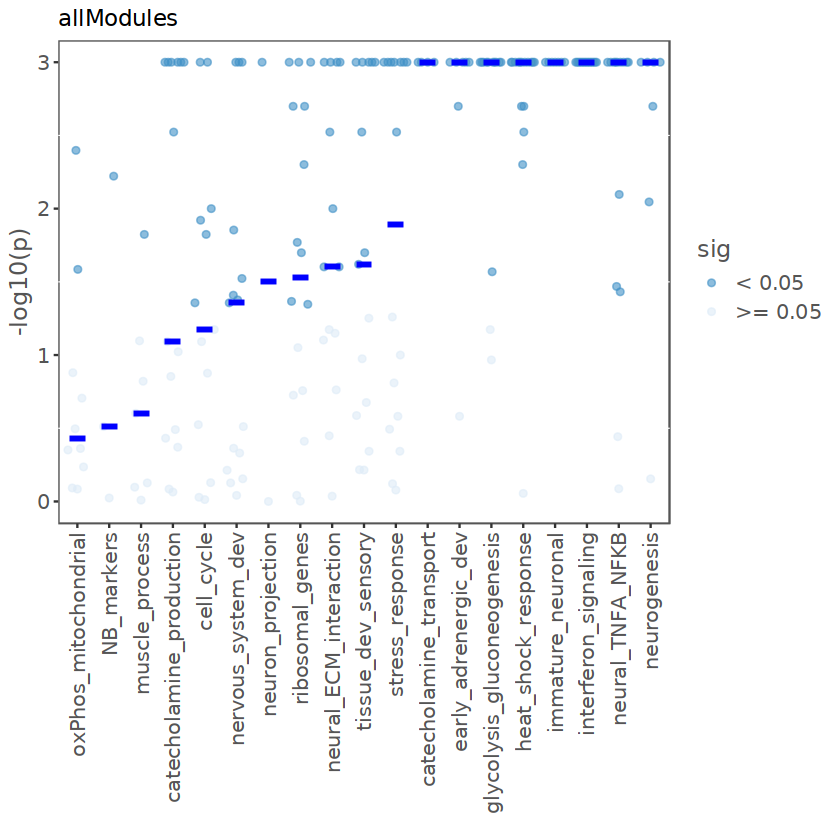

In [47]:
results_df_p_all_plot <- results_df_p_all_plot %>% mutate(Module_short = fct_reorder(Module_short, neglog10pval, .fun='median'))

ggplot(results_df_p_all_plot, aes(x = Module_short, y = neglog10pval)) +
            geom_quasirandom(aes(color = sig, group = 1),alpha = 0.6,dodge.width = 0.4) +
            scale_color_manual(values = c('#4292C6','#DEEBF7')) +
            stat_summary(fun = median, geom = "crossbar",
                         width = 0.5, color = "blue") +
            labs(title = 'allModules', x = '', y = '-log10(p)') +
            mytheme_angledX


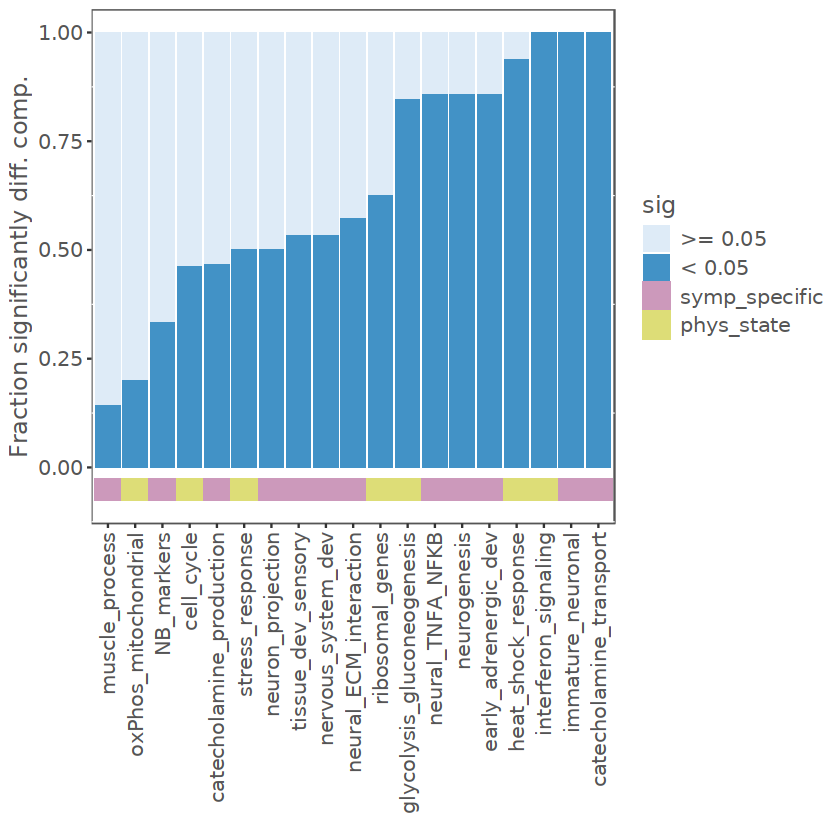

In [48]:
# Plot fraction significant / non-significant bar plots
test <- as.data.frame(table(results_df_p_all_plot$Module_short, results_df_p_all_plot$sig))
colnames(test) <- c('Module_short', 'sig','fraction')
test <- test[with(test, order(sig, fraction)), ]

# Calculate the total fraction for each module
test <- test %>%
  group_by(Module_short) %>%
  mutate(total_fraction = sum(fraction)) %>%
  ungroup()

# Calculate the fraction of each fraction value per sig value for each module
test <- test %>%
  mutate(fraction_of_total = fraction / total_fraction)

mod_type_vals_sub <- mod_type_vals[mod_type_vals$Module_short %in% test$Module_short,]
test <- left_join(test, mod_type_vals_sub, by = 'Module_short')

test$sig <- factor(as.character(test$sig), levels = c('>= 0.05','< 0.05'))
test <- test[with(test, order(sig,fraction_of_total)), ]
test$Module_short <- factor(as.character(test$Module_short), levels = rev(unique(test$Module_short)))
test$type <- factor(as.character(test$type), levels = c('symp_specific','phys_state'))

ggplot(test, aes(fill=sig, y=fraction, x=Module_short)) + 
            geom_bar(position="fill", stat="identity") +
            scale_fill_manual(values = c("#DEEBF7", "#4292C6",'#CC99BB','#DDDD77')) +
            labs(x = '', y = 'Fraction significantly diff. comp.') +
            geom_tile(aes(x=Module_short, y=-0.05, fill=type), height=0.05) +
            mytheme_angledX

##### average difference scores

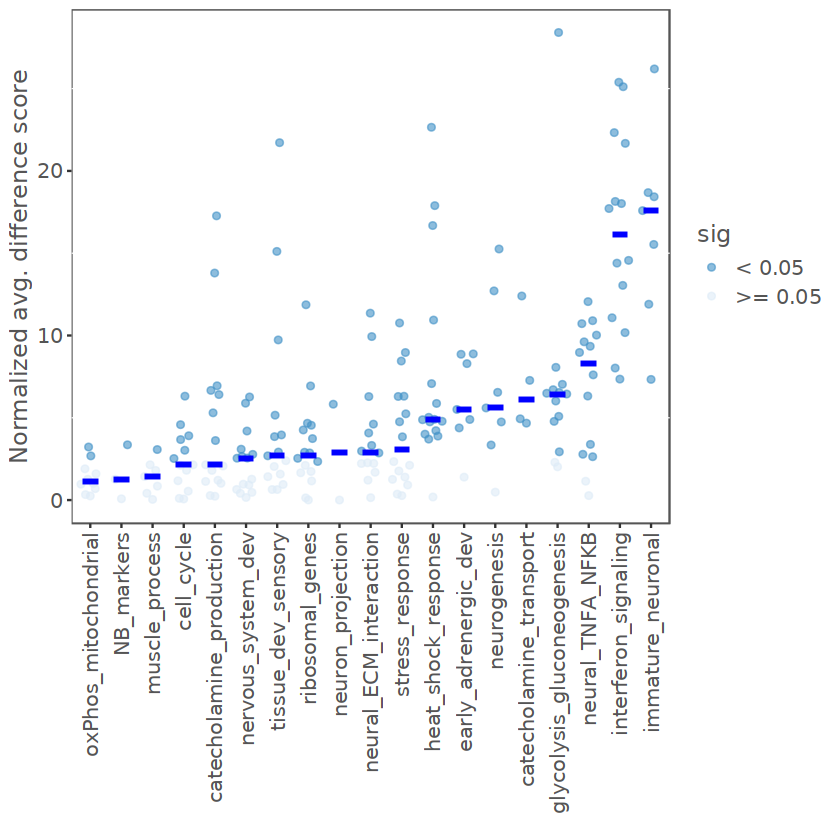

In [49]:
results_df_p_all_plot <- results_df_p_all_plot %>% mutate(Module_short = fct_reorder(Module_short, diff, .fun='median'))

ggplot(results_df_p_all_plot, aes(x = Module_short, y = diff)) +
            geom_quasirandom(aes(color = sig, group = 1),alpha = 0.6,dodge.width = 0.4) +
            scale_color_manual(values = c('#4292C6','#DEEBF7')) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            labs(x = '', y = 'Normalized avg. difference score') +
            mytheme_angledX


##### plot expression distribution for selected clone pairs

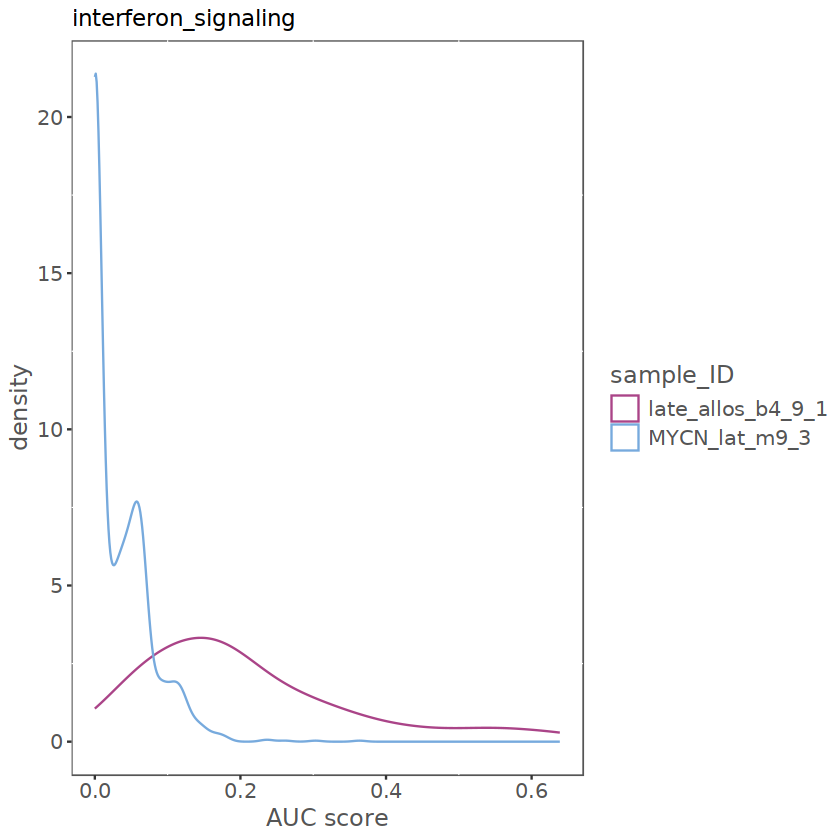

In [52]:
# Examples for late vs. primary
# Example 01
#mod <- 'immature_neuronal'
#clone_1 <- 'MYCN_lat_m9_3_multi_seq_09_3_36'
#clone_2 <- 'late_allos_b4_9_1_multi_seq_09_3_36'

# Example 02
mod <- 'interferon_signaling'
clone_1 <- 'MYCN_lat_m9_3_multi_seq_09_3_36'
clone_2 <- 'late_allos_b4_9_1_multi_seq_09_3_36'

mod_plot <- mod

# Add ID to module number depending on assay used
if(score_type == 'barkley'){
    mod_plot <- paste0('bark_',mod_plot)

}else if(score_type == 'auc'){
    mod_plot <- paste0('auc_',mod_plot)
        
}
    
sub_int <- dat@meta.data[dat@meta.data$tumorsample_clone %in% c(clone_1, clone_2),]

sub_int_plot <- sub_int
colnames(sub_int_plot)[grep(mod_plot, colnames(sub_int_plot))] <- 'mod_plot'

sub_int_plot$timepoint <- 'primary tum.'
sub_int_plot$timepoint[sub_int_plot$tumorsample_clone %like any% 'late%'] <- 'late graft tum.'
sub_int_plot$timepoint <- factor(as.character(sub_int_plot$timepoint), levels = c('primary tum.','late graft tum.'))


ggplot(sub_int_plot, aes(x = mod_plot, group = sample_ID, col = sample_ID)) +
                geom_density() +
                scale_color_manual(values = c(tol21rainbow[2],tol21rainbow[6])) +
                labs(x = 'AUC score', y = 'density', title = paste0(mod)) +
                mytheme_basic


#### Plot only for intra-tumor sample intra-timepoint (PT, early or graft) inter-clone


In [59]:
## Add a column for the average pct expressed in both clones
results_df_p_all_ann$pct_expr_clone_mean <- (results_df_p_all_ann$pct_expr_clone1 + results_df_p_all_ann$pct_expr_clone2)/2
results_df_p_all_plot_pre <- results_df_p_all_ann[results_df_p_all_ann$type == 'intraDataset_intraFish_intraTum',]

# Shorten module names
results_df_p_all_plot_pre$diff <- results_df_p_all_plot_pre$avg_diff_actual / results_df_p_all_plot_pre$avg_diff_perm_mean
results_df_p_all_plot_pre$diff[results_df_p_all_plot_pre$avg_diff_actual == 0 | results_df_p_all_plot_pre$avg_diff_perm_mean == 0] <- 0


##### p-values

In [60]:
# Set subset of comparisons to plot here
set_1 <- names(modules_pan)

dataset_type <- 'betweenClones_withinLateAllos' # betweenClones_withinPTs, betweenClones_withinEarlyAllos, betweenClones_withinLateAllos
set <- set_1
set_name <- 'Set_1'

results_df_p_all_plot <- results_df_p_all_plot_pre[results_df_p_all_plot_pre$timepoint_comp == dataset_type,]
results_df_p_all_plot <- results_df_p_all_plot[results_df_p_all_plot$Module_trans %in% set,]

In [61]:
# save median and mean difference scores
results_df_p_all_short <- results_df_p_all_plot[,c('Module_short','diff')]

df_median <- results_df_p_all_short %>%
  group_by(Module_short) %>%
  summarise(median_diff = median(diff))

df_mean <- results_df_p_all_short %>%
  group_by(Module_short) %>%
  summarise(mean_diff = mean(diff))

df_stats <- left_join(df_median,df_mean, by = 'Module_short')

write.csv(df_stats, paste0('./data/mean_and_median_intraTP_intraSample_diffScores_interClone_',dataset_type,'_',filt_name,"_Modules_",set_name,'.csv'), quote = F)

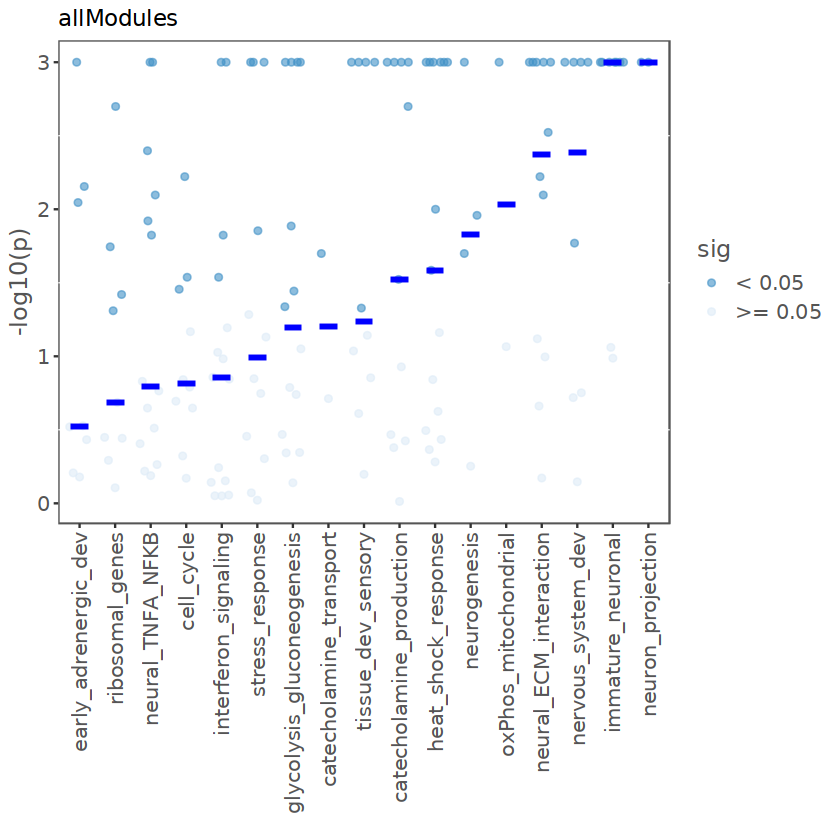

In [62]:
results_df_p_all_plot <- results_df_p_all_plot %>% mutate(Module_short = fct_reorder(Module_short, neglog10pval, .fun='median'))

ggplot(results_df_p_all_plot, aes(x = Module_short, y = neglog10pval)) +
            geom_quasirandom(aes(color = sig, group = 1),alpha = 0.6,dodge.width = 0.4) +
            scale_color_manual(values = c('#4292C6','#DEEBF7')) +
            stat_summary(fun = median, geom = "crossbar",
                         width = 0.5, color = "blue") +
            labs(title = 'allModules', x = '', y = '-log10(p)') +
            mytheme_angledX


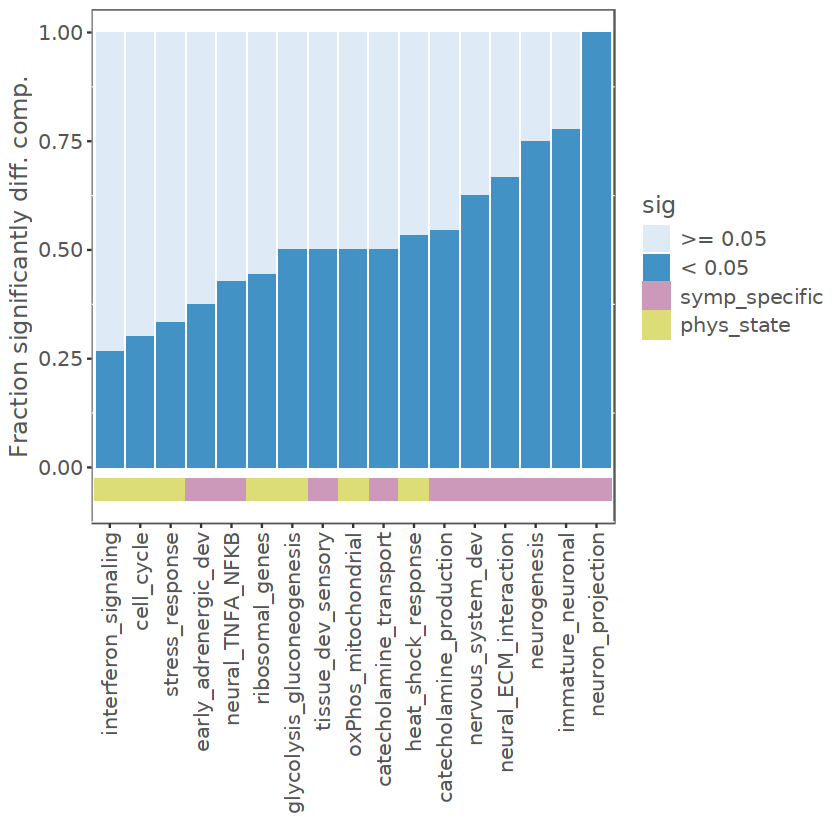

In [63]:
# Plot fraction significant / non-significant bar plots
test <- as.data.frame(table(results_df_p_all_plot$Module_short, results_df_p_all_plot$sig))
colnames(test) <- c('Module_short', 'sig','fraction')
test <- test[with(test, order(sig, fraction)), ]

# Calculate the total fraction for each module
test <- test %>%
  group_by(Module_short) %>%
  mutate(total_fraction = sum(fraction)) %>%
  ungroup()

# Calculate the fraction of each fraction value per sig value for each module
test <- test %>%
  mutate(fraction_of_total = fraction / total_fraction)

mod_type_vals_sub <- mod_type_vals[mod_type_vals$Module_short %in% test$Module_short,]
test <- left_join(test, mod_type_vals_sub, by = 'Module_short')

test$sig <- factor(as.character(test$sig), levels = c('>= 0.05','< 0.05'))
test <- test[with(test, order(sig,fraction_of_total)), ]
test$Module_short <- factor(as.character(test$Module_short), levels = rev(unique(test$Module_short)))
test$type <- factor(as.character(test$type), levels = c('symp_specific','phys_state'))

ggplot(test, aes(fill=sig, y=fraction, x=Module_short)) + 
            geom_bar(position="fill", stat="identity") +
            scale_fill_manual(values = c("#DEEBF7", "#4292C6",'#CC99BB','#DDDD77')) +
            labs(x = '', y = 'Fraction significantly diff. comp.') +
            geom_tile(aes(x=Module_short, y=-0.05, fill=type), height=0.05) +
            mytheme_angledX

##### average difference scores

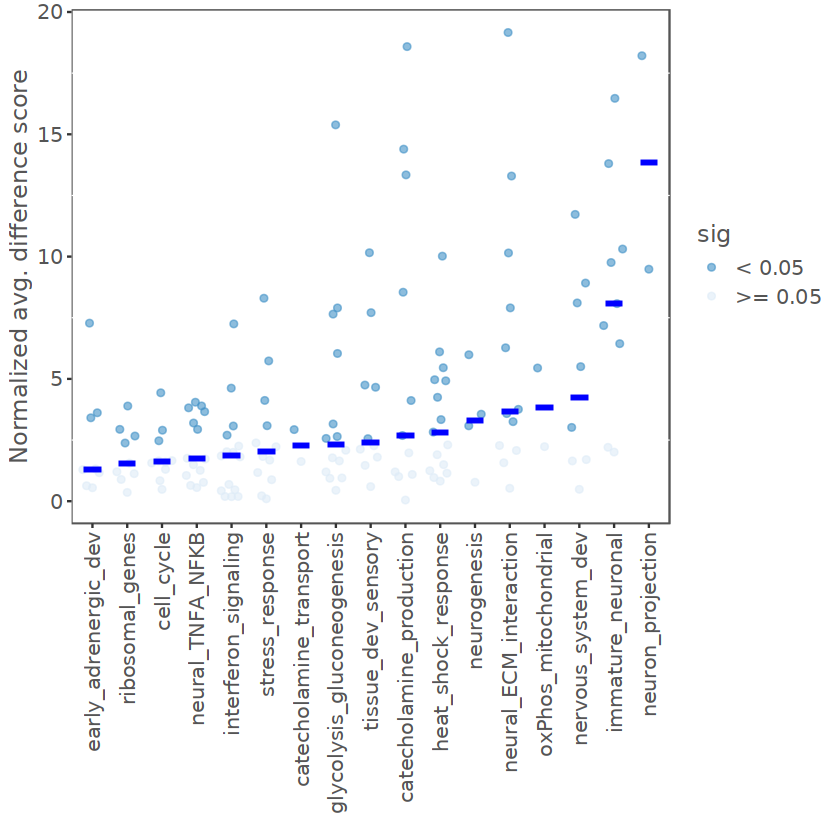

In [64]:
results_df_p_all_plot <- results_df_p_all_plot %>% mutate(Module_short = fct_reorder(Module_short, diff, .fun='median'))

ggplot(results_df_p_all_plot, aes(x = Module_short, y = diff)) +
            geom_quasirandom(aes(color = sig, group = 1),alpha = 0.6,dodge.width = 0.4) +
            scale_color_manual(values = c('#4292C6','#DEEBF7')) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            labs(x = '', y = 'Normalized avg. difference score') +
            mytheme_angledX


## Calculate gene module expression variance

### Reload and prepare data

In [46]:
# Load Seurat metadata with high-resolution clone assignments and module scores
dat <- readRDS('./data/seur_obj_allmerged_final_NB_with_clones_and_scores_withLowResClones.rds')

# Remove cells that have not been assigned to a clone
cells_keep <- rownames(dat@meta.data[!is.na(dat@meta.data$clone_all_tps),])
dim(dat)
dat <- subset(dat, cells = cells_keep)
dim(dat)

[1] 26338 57601

[1] 26338 25970

In [47]:
# Get order of modules in data
mod_order <- read.delim('./data/mod_name_order_in_data_allTPs.csv', sep = ',', stringsAsFactors = F, header = T, row.names = 1)

mod_order <- mod_order$x

module_metnames <- mod_order

In [49]:
# Load final module table
modules_pan <- read.delim('../gene_modules/final_gene_modules_list.csv', sep = ',', stringsAsFactors = F, header = T)

# Re-format into list
modules_pan <- as.list(modules_pan)

# Double-check that common gene names contain correct set of special characters
modules_pan <- lapply(modules_pan, function(x) gsub("si\\.","si:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("zgc\\.","zgc:",x))
modules_pan <- lapply(modules_pan, function(x) gsub("mt\\.","mt-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("dkey\\.","dkey-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("h211\\.","h211-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("1073\\.","1073-",x))
modules_pan <- lapply(modules_pan, function(x) gsub("ch73\\.","ch73-",x))

# Remove empty entries
modules_pan <- lapply(modules_pan, function(x) {
  # Remove NA and empty string "" entries
  x[!(is.na(x) | x == "")]
})

# Remove modules that are too short
modules_pan <- modules_pan[lengths(modules_pan) > 5]

In [50]:
# Create assay for the counts-based gene module expression scores
summed_assay <- CreateAssayObject(counts = t(Embeddings(dat, reduction = "scores_count")))

dat[["assay_count"]] <- summed_assay

# Create assay for  counts-based gene module expression scores together with all individual genes
gene_counts <- as.data.frame(t(as.matrix(GetAssayData(dat, slot = 'counts'))))
summed_assay <- as.data.frame(Embeddings(dat, reduction = "scores_count"))

gene_counts$cell <- rownames(gene_counts)
summed_assay$cell <- rownames(summed_assay)

gene_plus_mod_counts <- left_join(gene_counts, summed_assay, by = 'cell')
rownames(gene_plus_mod_counts) <- gene_plus_mod_counts$cell
gene_plus_mod_counts$cell <- NULL

table(rownames(gene_plus_mod_counts) == rownames(gene_counts))

gene_plus_mod_counts <- as(t(as.matrix(gene_plus_mod_counts)), "dgCMatrix")
summed_assay <- CreateAssayObject(counts = gene_plus_mod_counts)

dat[["assay_count_with_genes_logNorm"]] <- summed_assay

# Log-normalize the counts-based scores
# Make your custom assay the default (optional but convenient)
DefaultAssay(dat) <- "assay_count_with_genes_logNorm"

# Log-normalize this assay
dat <- NormalizeData(
  object = dat,
  assay  = "assay_count_with_genes_logNorm",
  normalization.method = "LogNormalize"
)


Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from assay_count_ to assaycount_”
Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 5.1 GiB”



 TRUE 
25970 

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from assay_count_with_genes_lognorm_ to assaycountwithgeneslognorm_”


### Calculate overall module expression variance in all NB cells

In [51]:
# set type of score to use
type <- 'count_with_genes_logNorm'

# Make sure that the log-normalized values are called by explicitly giving them to FindVariableFeatures
mat_norm <- GetAssayData(dat, assay = "assay_count_with_genes_logNorm", slot = "data")
# Seurat's internal FindVariableFeatures function is not exported; call with triple-colon:
vst_out_norm <- Seurat:::FindVariableFeatures(mat_norm, selection.method = "vst")

# Save results in variable
variable_features <- vst_out_norm


In [52]:
# Rename modules
orthos_vec <- module_metnames

# Add ID to module number depending on assay used
genes <- rownames(variable_features)
genes <- genes[!genes %like any% 'count-%']
orthos_vec <- c(orthos_vec, genes)
names(orthos_vec) <- c(paste0('count-',c(1:length(module_metnames))),genes)

orthos_vec <- orthos_vec[orthos_vec %in%  names(modules_pan)]

variable_features$mod_name <- revalue(rownames(variable_features), orthos_vec, warn_missing = T)

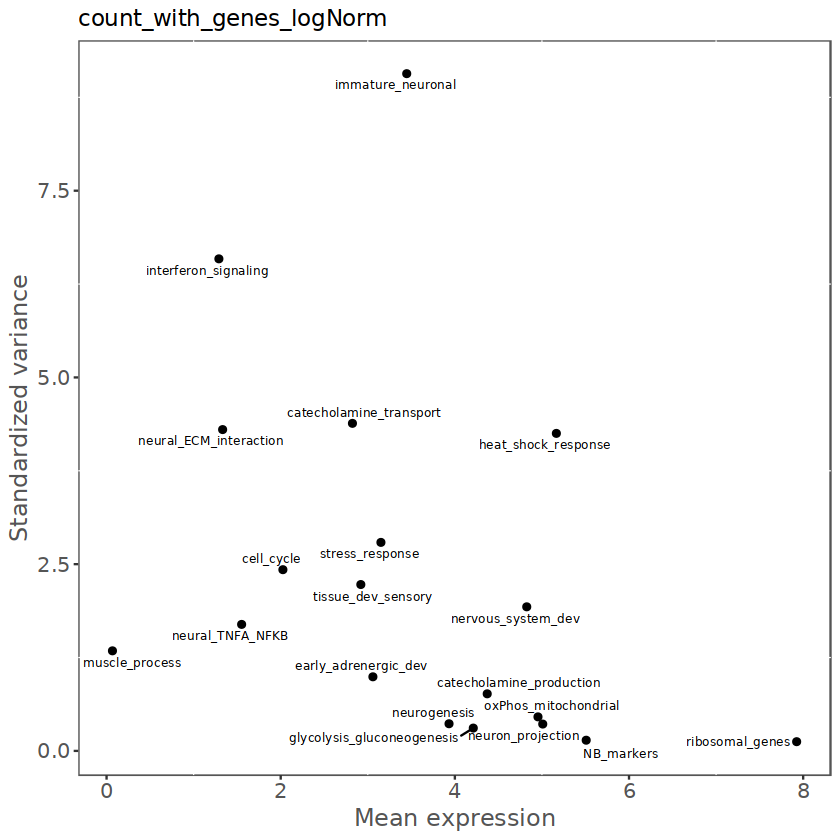

In [72]:
variable_features <- variable_features[!variable_features$mod_name %like any% 'count-%',]
variable_features$module <- 'yes'
variable_features$module[is.na(variable_features$mod_name)] <- 'no'
variable_features <- variable_features[rownames(variable_features) %like any% 'count-%',]

print(
    ggplot(variable_features, aes(x = vst.mean, y = vst.variance.standardized)) +
        geom_point() +
        scale_color_manual(values = c('dark grey','dark red')) +
        geom_text_repel(aes(label = mod_name), size = 2.5, max.overlaps = 30, box.padding = unit(0.2, "lines")) +
        labs(title = type, x = 'Mean expression', y = 'Standardized variance') +
        theme(legend.position="none") +
        mytheme_basic
)

### Calculate module expression variance in individual clones in individual (sub)tumors and timepoints

In [53]:
# Add proper naming column covering all subclones including location to metadata
dat@meta.data$dataset_timepoint_clones <- 'none'
dat@meta.data$dataset_timepoint_clones <- paste0(dat@meta.data$clone_all_tps,'_',dat@meta.data$sample_type)

# Remove cells that were not assigned to a clone
dat@meta.data$rem <- 'keep'
dat@meta.data$rem[is.na(dat@meta.data$clone_all_tps)] <- 'remove'

Idents(dat) <- 'rem'
dat <- subset(dat, idents = 'keep')

# Add a sample-clone identifier, in which early allograft cells are grouped by experiment (instead of per larval batch) and clone.
dat@meta.data$sample_sum <- dat@meta.data$sample_ID
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b1%'] <- 'early_allos_b1'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b2%'] <- 'early_allos_b2'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b3%'] <- 'early_allos_b3'
dat@meta.data$sample_sum[dat@meta.data$sample_ID %like any% 'early_allos_b4%'] <- 'early_allos_b4'

dat@meta.data$tumorsample_clone <- paste0(dat@meta.data$sample_sum,'_',dat@meta.data$clone_all_tps)


In [74]:
all_samples <- unique(dat@meta.data$tumorsample_clone)

type <- 'count_with_genes_logNorm'

Idents(dat) <- 'tumorsample_clone'

perTumVar <- data.frame()


for(i in 1:length(all_samples)){

    sample_i <- all_samples[i]
    sub_dat <- subset(dat, idents = sample_i)

    if(ncol(sub_dat) <= 30){
        print(paste0('Dataset ', sample_i, ' is too small.'))
        next
    }

    # Calculate vst and mean for a given score type
    mat_norm <- GetAssayData(sub_dat, assay = "assay_count_with_genes_logNorm", slot = "data")
    # Seurat's internal FindVariableFeatures function is not exported; call with triple-colon:
    variable_features <- Seurat:::FindVariableFeatures(mat_norm, selection.method = "vst")
    variable_features <- variable_features[rownames(variable_features) %like any% 'count-%',]
        
    variable_features$mod <- rownames(variable_features)
    variable_features$sample_all <- sample_i

    perTumVar <- rbind(perTumVar, variable_features)
    
}

write.csv(perTumVar, paste0('./data/module_variance_measures_per_TPcloneSublocation_scoreType_',type,'_',dat_name,'.csv'))


[1] "Dataset MYCN_LMO1_vent_m6_1_multi_seq_06_2_5 is too small."
[1] "Dataset MYCN_LMO1_vent_m6_1_multi_seq_06_2_2 is too small."
[1] "Dataset MYCN_LMO1_vent_m6_2_1_multi_seq_06_3_3 is too small."
[1] "Dataset MYCN_LMO1_vent_m6_2_1_multi_seq_06_3_1 is too small."
[1] "Dataset MYCN_LMO1_vent_m6_1_multi_seq_06_2_1 is too small."
[1] "Dataset MYCN_lat_m6_1_multi_seq_06_1_6 is too small."
[1] "Dataset MYCN_LMO1_vent_m6_2_1_multi_seq_06_3_11 is too small."
[1] "Dataset MYCN_lat_m6_1_multi_seq_06_1_10 is too small."
[1] "Dataset MYCN_lat_m6_1_multi_seq_06_1_1 is too small."
[1] "Dataset MYCN_lat_m6_1_multi_seq_06_1_7 is too small."
[1] "Dataset MYCN_LMO1_vent_m6_1_multi_seq_06_2_4 is too small."
[1] "Dataset MYCN_lat_m6_1_multi_seq_06_1_5 is too small."
[1] "Dataset MYCN_lat_m6_1_multi_seq_06_1_3 is too small."
[1] "Dataset MYCN_LMO1_vent_m6_2_1_multi_seq_06_3_6 is too small."
[1] "Dataset MYCN_LMO1_vent_m6_2_1_multi_seq_06_3_17 is too small."
[1] "Dataset MYCN_LMO1_vent_m6_2_1_multi_seq_06_

#### Reload and plot

In [56]:
type <- 'count_with_genes_logNorm'

perTumVar <- read.delim(paste0('./data/module_variance_measures_per_TPcloneSublocation_scoreType_',type,'_',dat_name,'.csv'), sep = ',', stringsAsFactors = F, row.names = 1)

b1 <- 1
b2 <- length(module_metnames)

module_names <- data.frame(matrix(,nrow=b2,ncol=0))
module_names$mod <- paste0('count-',c(b1:b2))
module_names$mod_name <- module_metnames

perTumVar <- left_join(perTumVar, module_names, by = 'mod')
perTumVar <- perTumVar[perTumVar$mod_name %in% names(modules_pan),]


In [57]:
# Filter: Set minimum fraction of cells of a clone in which a module has to be activated to keep comparison.
# This is typically set to 0.05, i.e. 5 % of cells in a clone need to show expression of the module.
# Expression fraction is always based on 'Barkley' scores. Therefore, load expression stats generated from this type of score.

filt_type <- '0.05'

# Filter if desired
dim(perTumVar)
if(filt_type == 'all'){
    
    perTumVar_plot <- perTumVar
    
}else{

    stats_df <- read.delim('./data/expr_stats_lowResClone_sublocations_TP_pairs_modType_auc.csv', sep = ',', header = T, row.names = 1)

    stats_df_1 <- stats_df[,c('Clone1','pct_expr_clone1', 'Module')]
    stats_df_2 <- stats_df[,c('Clone2','pct_expr_clone2', 'Module')]
    colnames(stats_df_1) <- c('Clone','pct_expr_clone', 'Module')
    colnames(stats_df_2) <- c('Clone','pct_expr_clone', 'Module')
    stats_df <- rbind(stats_df_1, stats_df_2)
    
    stats_df$Module <- gsub('bark_','count-',stats_df$Module)
    stats_df$Module <- gsub('auc_','count-',stats_df$Module)

    stats_df$clone_mod <- paste0(stats_df$Clone, '_',stats_df$Module)
    stats_df <- stats_df[!duplicated(stats_df$clone_mod),]
    stats_df <- stats_df[stats_df$pct_expr_clone >= filt_type,]

    perTumVar$clone_mod <- paste0(perTumVar$sample_all,'_', perTumVar$mod)
    perTumVar_plot <- perTumVar[perTumVar$clone_mod %in% stats_df$clone_mod,]
}

dim(perTumVar_plot)

write.csv(perTumVar_plot,paste0('./data/module_variance_measures_per_TPcloneSublocation_scoreType_',type,"_",dat_name,'_filtered_',filt_type,'.csv'))


[1] 1843    7

[1] 739   8

In [59]:
# Reload and plot

type <- 'count_with_genes_logNorm'
filt_type <- '0.05'

perTumVar_plot <- read.delim(paste0('./data/module_variance_measures_per_TPcloneSublocation_scoreType_',type,"_",dat_name,'_filtered_',filt_type,'.csv'), stringsAsFactors = F, sep = ',', row.names = 1, header = T)
perTumVar_plot <- perTumVar_plot[!is.na(perTumVar_plot$vst.variance.standardized),]

perTumVar_sub <- perTumVar_plot

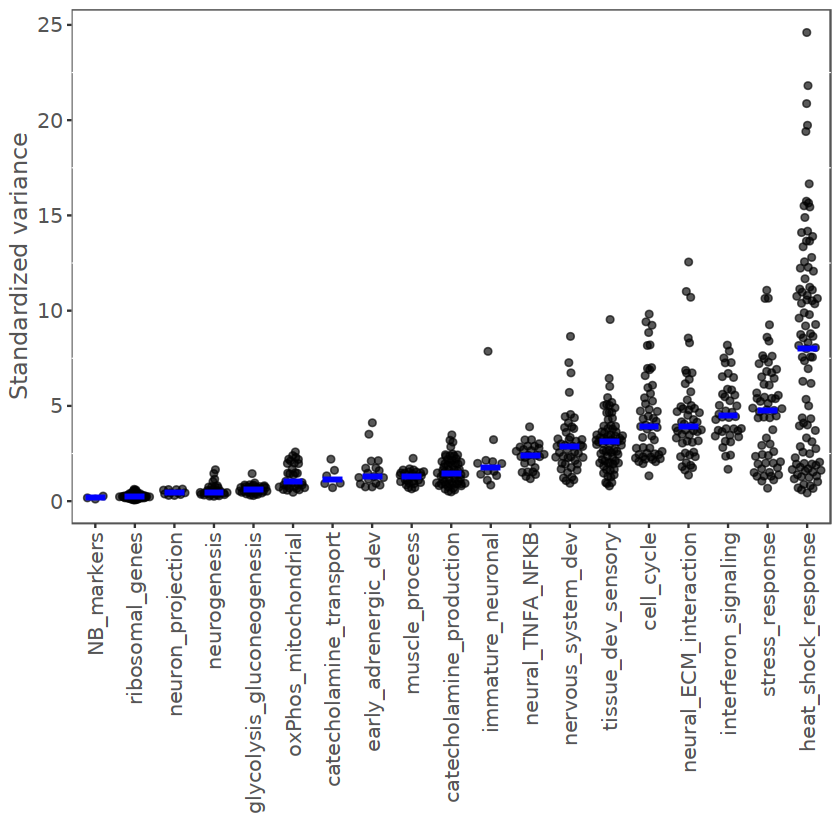

In [60]:
## For all clones
perTumVar_plot <- perTumVar_sub
perTumVar_plot <- perTumVar_plot %>% mutate(mod_name = fct_reorder(mod_name, vst.variance.standardized, .fun='median'))

ggplot(perTumVar_plot, aes(x = mod_name, y = vst.variance.standardized)) +
            geom_quasirandom(alpha = 0.65,dodge.width = 0.4) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            #scale_color_manual(values = tol21rainbow[c(4,15)]) +
            labs(x = '', y = 'Standardized variance') +
            mytheme_angledX


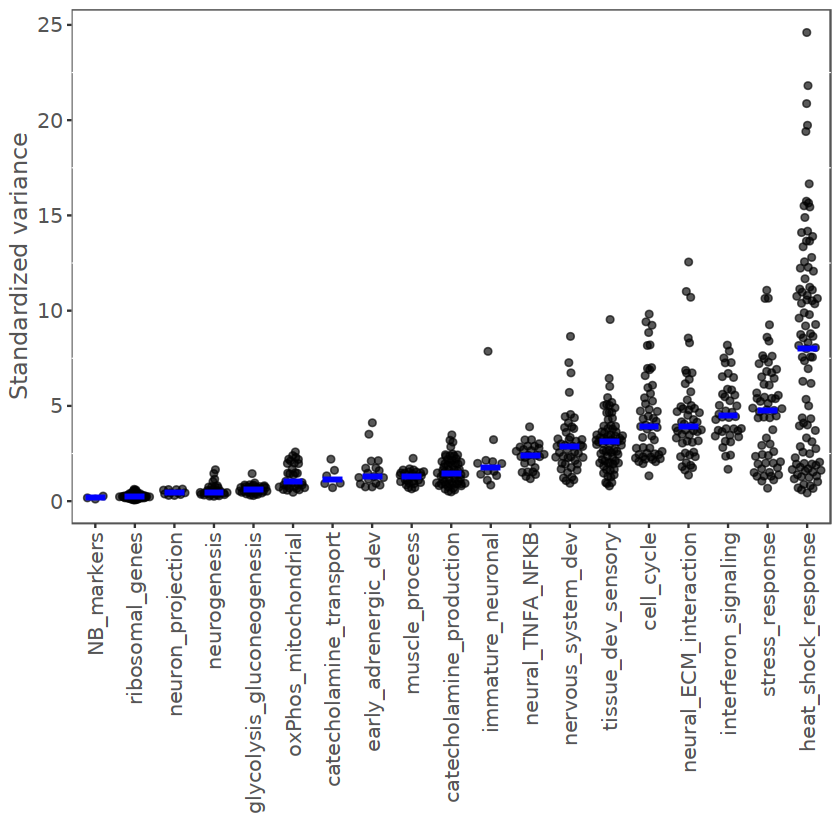

In [61]:
# For all samples
perTumVar_plot <- perTumVar_sub

perTumVar_plot <- perTumVar_plot %>% mutate(mod_name = fct_reorder(mod_name, vst.variance.standardized, .fun='median'))

ggplot(perTumVar_plot, aes(x = mod_name, y = vst.variance.standardized)) +
            geom_quasirandom(alpha = 0.65,dodge.width = 0.4) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            #scale_color_manual(values = tol21rainbow[c(4,15)]) +
            labs(x = '', y = 'Standardized variance') +
            mytheme_angledX


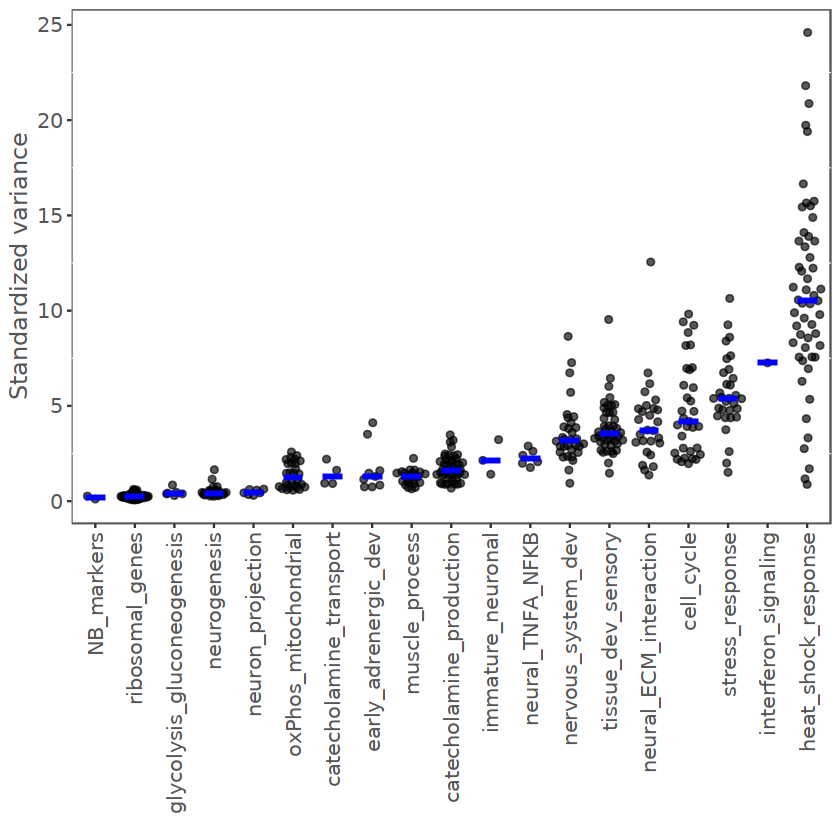

In [62]:
# For primary tumors
perTumVar_plot <- perTumVar_sub[!perTumVar_sub$sample_all %like any% '%allos%',]

perTumVar_plot <- perTumVar_plot %>% mutate(mod_name = fct_reorder(mod_name, vst.variance.standardized, .fun='median'))

ggplot(perTumVar_plot, aes(x = mod_name, y = vst.variance.standardized)) +
            geom_quasirandom(alpha = 0.65,dodge.width = 0.4) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            labs(x = '', y = 'Standardized variance') +
            mytheme_angledX


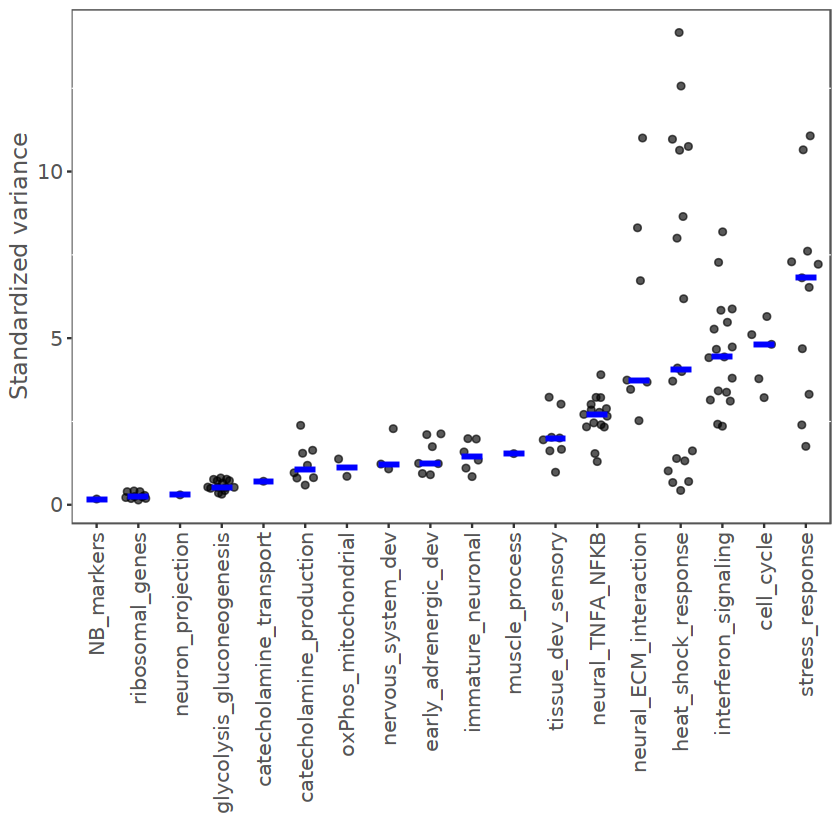

In [63]:
# For late allografts
perTumVar_plot <- perTumVar_sub[perTumVar_sub$sample_all %like any% 'late_allos%',]

perTumVar_plot <- perTumVar_plot %>% mutate(mod_name = fct_reorder(mod_name, vst.variance.standardized, .fun='median'))

ggplot(perTumVar_plot, aes(x = mod_name, y = vst.variance.standardized)) +
            geom_quasirandom(alpha = 0.65,dodge.width = 0.4) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            labs(x = '', y = 'Standardized variance') +
            mytheme_angledX


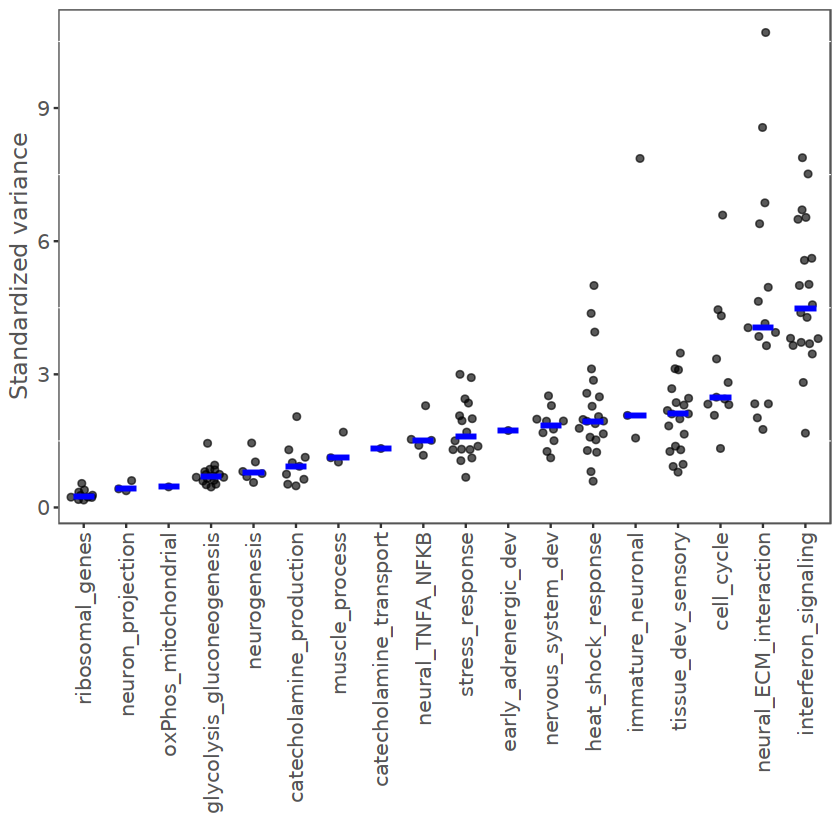

In [64]:
## For early allografts
perTumVar_plot <- perTumVar_sub[perTumVar_sub$sample_all %like any% 'early_allos%',]

perTumVar_plot <- perTumVar_plot %>% mutate(mod_name = fct_reorder(mod_name, vst.variance.standardized, .fun='median'))

ggplot(perTumVar_plot, aes(x = mod_name, y = vst.variance.standardized)) +
            geom_quasirandom(alpha = 0.65,dodge.width = 0.4) +
            stat_summary(fun = median, geom = "crossbar",
                         width = .5, color = "blue") +
            labs(x = '', y = 'Standardized variance') +
            mytheme_angledX


##### Three TP intra-clone variance plots

In [72]:
## Load PT intra-clone variances
perTumVar_plot_pts <- read.delim('./data/module_variance_measures_per_clone_scoreType_count_with_genes_logNorm_allClones_new_filtered_0.05.csv',
                            stringsAsFactors = F, sep = ',', row.names = 1, header = T)

# Load for allografts
type <- 'count_with_genes_logNorm'
filt_type <- '0.05'

perTumVar_sub <- read.delim(paste0('./data/module_variance_measures_per_TPcloneSublocation_scoreType_',type,'_',dat_name,'_filtered_',filt_type,'.csv'), stringsAsFactors = F, sep = ',', row.names = 1, header = T)
perTumVar_sub <- perTumVar_sub[!is.na(perTumVar_sub$vst.variance.standardized),]

perTumVar_sub <- perTumVar_sub[!perTumVar_sub$mod_name %like any% c('eAs_%','lAs_%'),]
perTumVar_plot_late <- perTumVar_sub[perTumVar_sub$sample_all %like any% '%ate_allos%',]
perTumVar_plot_early <- perTumVar_sub[perTumVar_sub$sample_all %like any% '%ly_allos%',]


In [83]:
# save median and mean difference scores
perTumVar_plot_pts <- perTumVar_plot_pts[,c('mod_name','vst.variance.standardized')]

df_median_pt <- perTumVar_plot_pts %>%
  group_by(mod_name) %>%
  summarise(median_var = median(vst.variance.standardized))

df_mean_pt <- perTumVar_plot_pts %>%
  group_by(mod_name) %>%
  summarise(mean_var = mean(vst.variance.standardized))


perTumVar_plot_late <- perTumVar_plot_late[,c('mod_name','vst.variance.standardized')]

df_median_late <- perTumVar_plot_late %>%
  group_by(mod_name) %>%
  summarise(median_var = median(vst.variance.standardized))

df_mean_late <- perTumVar_plot_late %>%
  group_by(mod_name) %>%
  summarise(mean_var = mean(vst.variance.standardized))


perTumVar_plot_early <- perTumVar_plot_early[,c('mod_name','vst.variance.standardized')]

df_median_early <- perTumVar_plot_early %>%
  group_by(mod_name) %>%
  summarise(median_var = median(vst.variance.standardized))

df_mean_early <- perTumVar_plot_early %>%
  group_by(mod_name) %>%
  summarise(mean_var = mean(vst.variance.standardized))


df_median_pt$condition <- 'primary_tumor'
df_median_early$condition <- 'early_allograft'
df_median_late$condition <- 'late_allograft'

dim(df_median_pt)
dim(df_median_early)
dim(df_median_late)

df_all_pt <- left_join(df_median_pt, df_mean_pt, by = 'mod_name')

df_all_early <- left_join(df_median_early, df_mean_early, by = 'mod_name')
    add_row <- as.data.frame(t(c('NB_markers',0,'early_allograft',0)))
    colnames(add_row) <- c('mod_name','median_var','condition','mean_var')
    add_row$median_var <- as.numeric(add_row$median_var)
    add_row$mean_var <- as.numeric(add_row$mean_var)
    df_all_early <- rbind(df_all_early, add_row)

df_all_late <- left_join(df_median_late, df_mean_late, by = 'mod_name')
    add_row <- as.data.frame(t(c('NB_markers',0,'late_allograft',0)))
    colnames(add_row) <- c('mod_name','median_var','condition','mean_var')
    add_row$median_var <- as.numeric(add_row$median_var)
    add_row$mean_var <- as.numeric(add_row$mean_var)
    df_all_late <- rbind(df_all_late, add_row)

all_vars <- rbind(df_all_pt, df_all_early, df_all_late)

all_vars$mod_cond <- paste0(all_vars$mod_name, '_', all_vars$condition)


[1] 19  3

[1] 18  3

[1] 18  3

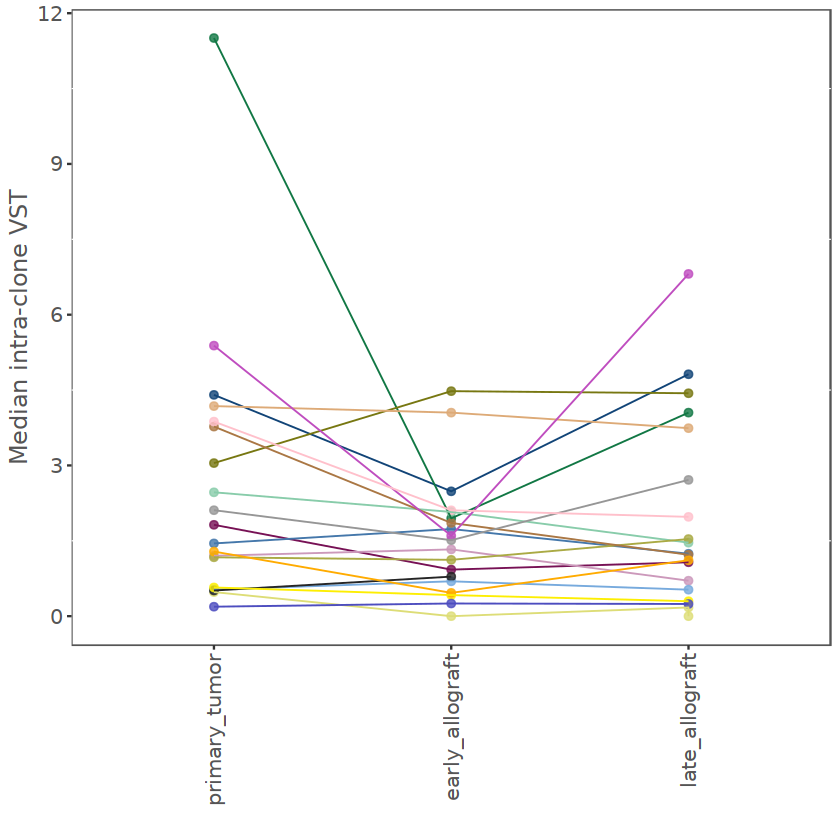

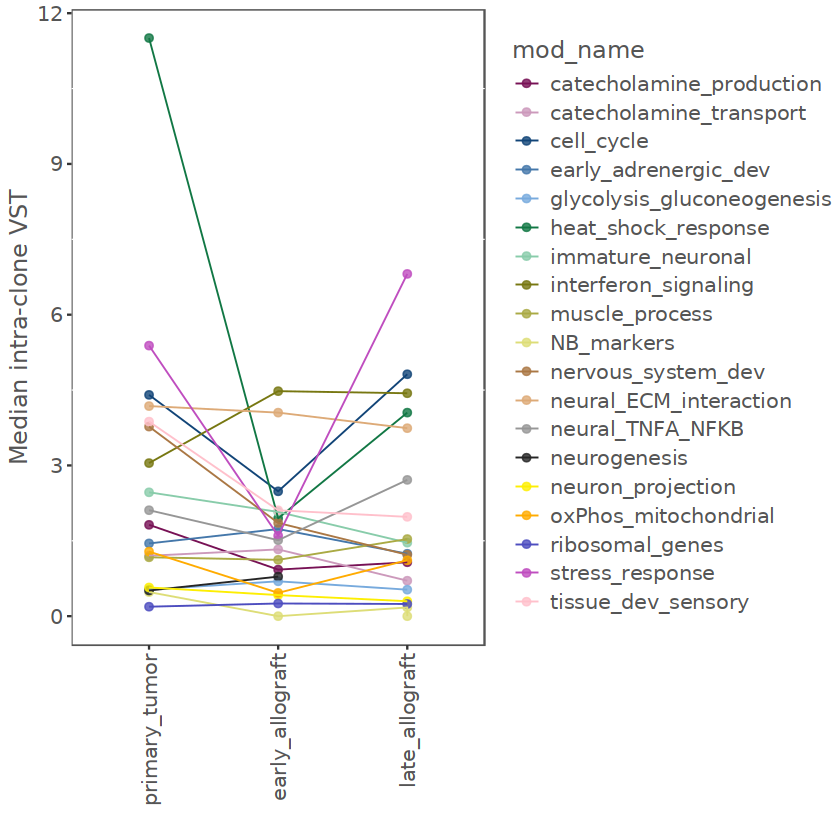

In [85]:
all_vars$mod_name <- as.character(all_vars$mod_name)
all_vars$condition <- as.character(all_vars$condition)
all_vars$condition <- factor(all_vars$condition, levels = c('primary_tumor','early_allograft','late_allograft'))

ggplot(all_vars, aes(x = condition, y = median_var, fill = condition, col = mod_name)) +
                geom_point(alpha = 0.8, size = 1.7) +
                geom_line(aes(group = mod_name), size = 0.4) +
                scale_color_manual(values = c(tol21rainbow[c(1,3,4,5,6,10,12,13,14,15,17,18,23,24,29,30,31,32)],'pink','green','orange')) +
                guides(fill = 'none', col = 'none') +
                ylab(paste0("Median intra-clone VST")) +
                xlab('') +
                mytheme_angledX 

# With legend
ggplot(all_vars, aes(x = condition, y = median_var, fill = condition, col = mod_name)) +
                geom_point(alpha = 0.8, size = 1.7) +
                geom_line(aes(group = mod_name), size = 0.4) +
                scale_color_manual(values = c(tol21rainbow[c(1,3,4,5,6,10,12,13,14,15,17,18,23,24,29,30,31,32)],'pink','green','orange')) +
                ylab(paste0("Median intra-clone VST")) +
                guides(fill = 'none') +
                xlab('') +
                mytheme_angledX 


##### Three TP inter-clone difference plots

In [148]:
# reload for primary tumors
diff_sores_pt_clones <- read.delim('./data/mean_and_median_interClon_diffScores_auc_comps_over_5_pct.csv', sep = ',', stringsAsFactors = F, row.names = 1)
colnames(diff_sores_pt_clones) <- c('mod_name','median_diff','mean_diff')
diff_sores_pt_clones$condition <- 'primary_tumor'

In [149]:
# Load for allografts

diff_sores_interCloneLate <- read.delim('./data/mean_and_median_intraTP_intraSample_diffScores_interClone_betweenClones_withinLateAllos_comps_over_5_pct_Modules_Set_1.csv', sep = ',', stringsAsFactors = F, row.names = 1)
colnames(diff_sores_interCloneLate) <- c('mod_name','median_diff','mean_diff')
# Add a 0 for missing modules, as apparently not all were expressed at high enough levels anywhere in the samples to make it into the table
add_row <- rbind(as.data.frame(t(c('NB_markers',0,0))), as.data.frame(t(c('muscle_process',0,0))))
colnames(add_row) <- c('mod_name','median_diff','mean_diff')
add_row$median_diff <- as.numeric(add_row$median_diff)
add_row$mean_diff <- as.numeric(add_row$mean_diff)

diff_sores_interCloneLate <- rbind(diff_sores_interCloneLate, add_row)
dim(diff_sores_interCloneLate)
diff_sores_interCloneLate$condition <- 'late_allograft'

    
diff_sores_early <- read.delim('./data/mean_and_median_intraTP_intraSample_diffScores_interClone_betweenClones_withinEarlyAllos_comps_over_5_pct_Modules_Set_1.csv', sep = ',', stringsAsFactors = F, row.names = 1)
colnames(diff_sores_early) <- c('mod_name','median_diff','mean_diff')
# Add a 0 for missing modules, as apparently not all were expressed at high enough levels anywhere in the samples to make it into the table
add_row <- rbind(as.data.frame(t(c('NB_markers',0,0))))
colnames(add_row) <- c('mod_name','median_diff','mean_diff')
add_row$median_diff <- as.numeric(add_row$median_diff)
add_row$mean_diff <- as.numeric(add_row$mean_diff)

diff_sores_early <- rbind(diff_sores_early, add_row)
dim(diff_sores_early)
diff_sores_early$condition <- 'early_allograft'


[1] 19  3

[1] 19  3

In [150]:
diff_sores_pt_clones$mod_name_1 <- diff_sores_pt_clones$mod_name
diff_sores_pt_clones$mod_name_2 <- diff_sores_pt_clones$mod_name
diff_sores_pt_clones$mod_name_1[c(1,3,6,8,9,10,12,15,18)] <- NA
diff_sores_pt_clones$mod_name_2[!is.na(diff_sores_pt_clones$mod_name_1)] <- NA

diff_sores_interCloneLate$mod_name_1 <- diff_sores_interCloneLate$mod_name
diff_sores_interCloneLate$mod_name_2 <- diff_sores_interCloneLate$mod_name
diff_sores_interCloneLate$mod_name_1[c(1,3,6,8,9,10,12,15,18)] <- NA
diff_sores_interCloneLate$mod_name_2[!is.na(diff_sores_interCloneLate$mod_name_1)] <- NA

diff_sores_early$mod_name_1 <- diff_sores_early$mod_name
diff_sores_early$mod_name_2 <- diff_sores_early$mod_name
diff_sores_early$mod_name_1[c(1,3,6,8,9,10,12,15,18)] <- NA
diff_sores_early$mod_name_2[!is.na(diff_sores_early$mod_name_1)] <- NA


In [151]:
df_median_all <- rbind(diff_sores_pt_clones, diff_sores_interCloneLate, diff_sores_early)


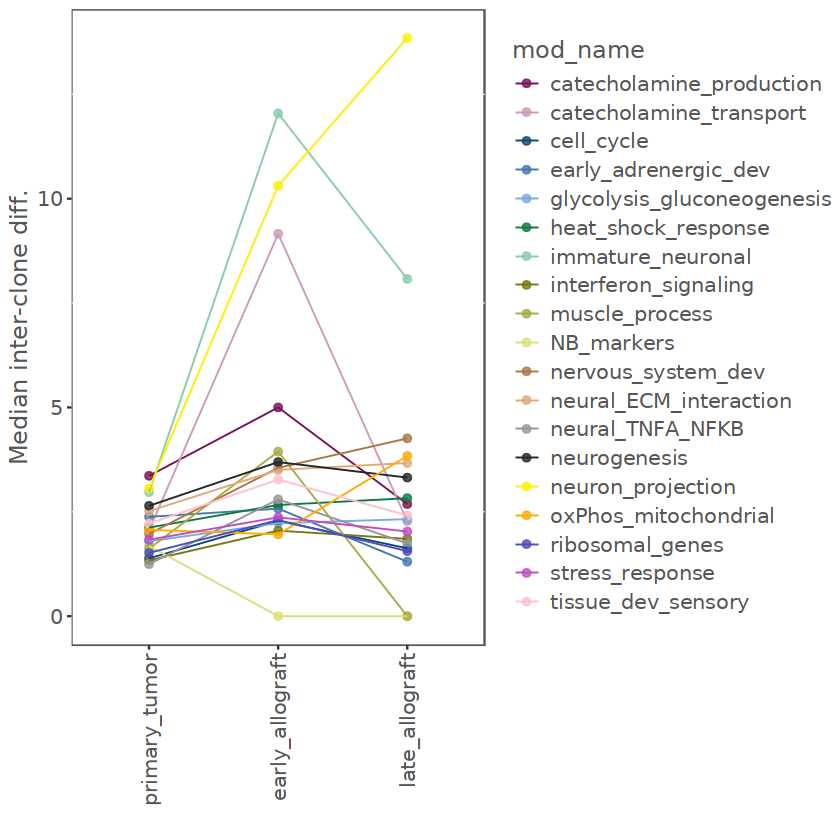

In [153]:
df_median_all$mod_name <- as.character(df_median_all$mod_name)
df_median_all$condition <- as.character(df_median_all$condition)
df_median_all$condition <- factor(df_median_all$condition, levels = c('primary_tumor','early_allograft','late_allograft'))

ggplot(df_median_all, aes(x = condition, y = median_diff, fill = condition, col = mod_name)) +
                geom_point(alpha = 0.8, size = 1.7) +
                geom_line(aes(group = mod_name), size = 0.4) +
                scale_color_manual(values = c(tol21rainbow[c(1,3,4,5,6,10,12,13,14,15,17,18,23,24,29,30,31,32)],'pink','green','orange')) +
                guides(fill = 'none') +
                ylab(paste0("Median inter-clone diff.")) +
                xlab('') +
                mytheme_angledX 


#### Plot inter-clone difference in PTs vs inter-TP expression difference

In [87]:
diff_sores_pt_clones <- read.delim('./data/mean_and_median_interClon_diffScores_auc_comps_over_5_pct.csv', sep = ',', stringsAsFactors = F, row.names = 1)
colnames(diff_sores_pt_clones) <- c('Module_short','median_diff_pts','mean_diff_pts')

diff_sores_pt_vs_late <- read.delim('./data/mean_and_median_interTP_intraClone_diffScores_interClone_betweenTimepoints_PT_vs_late_Modules_comps_over_5_pct_Set_1.csv', sep = ',', stringsAsFactors = F, row.names = 1)
colnames(diff_sores_pt_vs_late) <- c('Module_short','median_diff_late','mean_diff_late')


In [88]:
diff_sores_pt_vs_late <- diff_sores_pt_vs_late[!diff_sores_pt_vs_late$Module_short %like any% 'lAs%',]
diff_sores_pt_vs_late <- diff_sores_pt_vs_late[!diff_sores_pt_vs_late$Module_short %like any% 'eAs%',]

all_diff_exp <- left_join(diff_sores_pt_clones, diff_sores_pt_vs_late, by = 'Module_short')

In [89]:
all_diff_exp$cat <- 'both_low'
all_diff_exp$Module_some <- all_diff_exp$Module_short
all_diff_exp$cat[all_diff_exp$Module_short %in% c('heat_shock_response','stress_response','cell_cycle','interferon_signaling')] <- 'phys_state'
all_diff_exp$cat[all_diff_exp$Module_short %in% c('catecholamine_production','immature_neuronal','neurogenesis','neural_ECM_interaction','neuron_projection')] <- 'symp_specific'
all_diff_exp$Module_some[all_diff_exp$cat == 'both_low'] <- NA

all_diff_exp$cat <- factor(as.character(all_diff_exp$cat), levels = c('both_low','symp_specific','phys_state'))

Warning message in geom_label_repel(aes(label = Module_some), size = 3.5, label.size = 0.01, :
“Ignoring unknown parameters: `linewidth`”
Warning message:
“Removed 10 rows containing missing values or values outside the scale range (`geom_label_repel()`).”


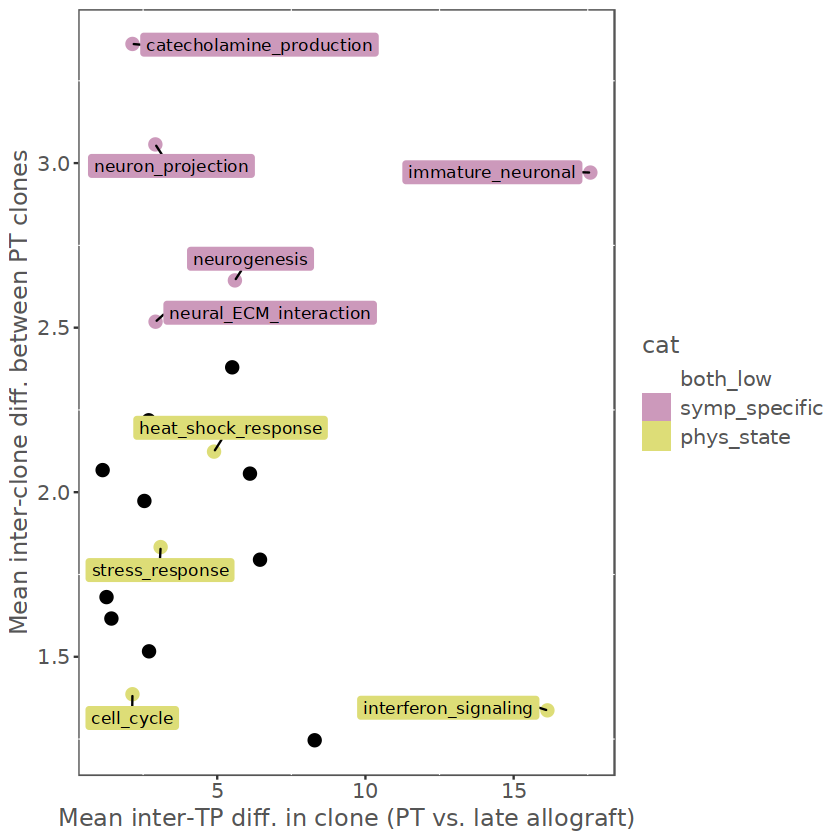

In [91]:
    ggplot(all_diff_exp, aes(x = median_diff_late, y = median_diff_pts, col = cat, fill = cat)) +
                geom_point(size = 3) +
                geom_label_repel(aes(label = Module_some), size = 3.5, label.size = 0.01, linewidth = 0.1,
                                 max.overlaps = 50, box.padding = 0.3, point.padding = 0, color = 'black',
                                 force = 20, min.segment.length = 0, alpha = 1, seed = 123) +
                scale_color_manual(values = c('black','#CC99BB','#DDDD77')) +
                scale_fill_manual(values = c('#FFFFFF80','#CC99BB80','#DDDD7780')) +
                labs(x = 'Mean inter-TP diff. in clone (PT vs. late allograft)', y = 'Mean inter-clone diff. between PT clones') +
                guides(fill = guide_legend(override.aes = aes(color = NA))) +
                mytheme_basic